<img src="../figures/banner.png" alt="banner" class="center" style="max-width: 90%">

# Modelling, tuning and evaluation

## Table of contents

- [1. Introduction](#intro)

- [2. Loading data](#loading_data)

- [3. Preprocessing](#preprocessing)

- [4. Modelling](#modelling)

- [5. Tuning](#tuning)

- [6. Evaluation](#evaluation)

- [7. Calculate customer scores](#scores)

- [8. Model interpretability](#interpretability)

## 1. Introduction <a class="anchor" id="intro"></a>

* The purpose of this notebook is to build a machine learning model for credit scoring: 
    - loading and preprocessing data for machine learning, 
    - fitting and tuning different machine learning models, and 
    - evaluate the different models. 
    
    
* The model is an MVP which means it will serve to demonstrate how Machine Learning can create value to ConectCar business.

* Further more the MVP presented here can be improved as the AWS datalake and data science skills are installed in the company, and the business case is refined and constrained.


### 1.1 Objective

* Build a model that can assign a credit score to each of ConnectCar customers. The score measures how likely is the customer to default on a loan after the first 15 days.

### 1.2 How the model is going to be used.

1. First, you give to the model information of a customer.

2. Second, the model crunches numbers and generates a score of how likely the client will not repay on time ConectCar in case we lend him money to complete a transaction. (Note: The score is calculated as the probability of the client not repaying in a reasonable time if given a loan to complete his transaction.)

3. Third, based on the score ConectCar decides what is best for the customer and the company:
    - to lend the customer money or not.
    - to design new ways of payment based on credit score.
    - to plan a strategy that prioritizes debt collection.
    - to offer new services to retain loyal customers.
    - to offer solutions to customers that are likely to leave the company or repay after many days.

 
### 1.3 Definitions

- **algorithm**: An “algorithm” in machine learning is a procedure that is run on data to create a machine learning “model". Machine learning algorithms perform “pattern recognition". Algorithms “learn” from data, or are “fit” on a dataset. There are many machine learning algorithms for supervised learning such as Logistic Regression, Decision Trees, Random Forest, Xgboost, Catboost and LightGBM, among many others. 
- **binary classification**: It is a machine learning problem where we want to train a model to separate observations in two classes (default or not default; fraud or not fraud).
- **classification problem**: It is a supervised learning problem where the outcome variable that wants to be predicted is a class, such as defaulted or not defaulted, fraudulent or not fraudulent, and churn or not churn. A classification problem can also produce probabilities for each class.
- **default**: A client does not repay ConectCar a loan to complete a transaction within the first X days.
- **features**: Characteristics of a customer such as sex, estado civil, estado, plan, average balance, average recharge, etc.
- **loan**: Money lent by ConectCar to the client to complete a transaction when he ran out of money in his account.
- **pipeline**: All the necessary steps needed to pass from raw input to a machine learning prediction. All steps should be reproducible, so when new data arrives, the same pipeline can be applied to get predictions.
- **reproducibility**: Ensuring that a data scientist can replicate an analysis using the same data and code.
- **supervised learning**: It is the machine learning task of learning a function that maps an input (set of characteristics) to an output (desired outcome) based on example input-output pairs. It infers a function from labeled training data consisting of a set of training examples. A supervised learning algorithm analyzes the training data and produces an inferred function, which can be used for mapping new examples. An optimal scenario will allow for the algorithm to correctly determine the class labels for unseen instances. The quality of an algorithm inferred function is measured through the so-called generalization error. 
- **target**: The variable we will predict in a supervised learning problem.

### 1.4 Setup <a class="anchor" id="setup"></a>

* This notebook runs in a `ml.t3.xlarge` instance with 4 vCPU + 16 GiB or in a `ml.m5.xlarge` with 8 vCPU + 16 GiB

* Run this cell to reload any python scripts you are working on automatically, without restarting Jupyter Lab.

In [2]:
%load_ext autoreload
%autoreload 2

* To ensure reproducibility please run the following cell. It will install visualization libraries, the xgboost, catboost and lightgbm models and other dependencies.

In [3]:
!pip install seaborn==0.11.2
!pip install plotnine==0.8.0
!pip install yellowbrick
!pip install scikit-learn==1.0.1
!pip install xgboost==1.5.0
!pip install lightgbm==3.3.1
!pip install catboost==1.0.3
!pytest-cov
!pytest-filter-subpackage
!apt-get update && apt-get install -y build-essential
!python -m pip install shap
!pip install psycopg2-binary sqlalchemy-redshift sqlalchemy
!pip install plotnine==0.8.0
!pip install pandas_bokeh 

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptograp

* Load relevant libraries and configure Jupyter Lab.

In [4]:
# Data preprocessing
import pandas as pd
import numpy as np

# Visualization
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_bokeh

# AWS
import boto3

# Others
import joblib
import json
import psycopg2

# Configuring notebook
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pandas_bokeh.output_notebook() # https://github.com/PatrikHlobil/Pandas-Bokeh

# Setting reproducibility seed
seed = 42

Loading BokehJS ...

-------

## 2. Loading data <a class="anchor" id="loading_data"></a>

* In this section we are going to import the data from Amazon Redshift, we are going to filter the customers and we are going to split our final dataset in training, validation and test sets.

* To retrieve the dataset from Amazon RedShift the first step is to create a connection from Jupyter Lab in Sagemaker to the database. For this purpose we are going to retrieve the database credentials (`username` and `password`) from AWS secrets manager using `boto3` and `secretsmanager`. Note that to ensure the highest security standards you will need to create database credentials for each data scientist (see [AWS Secrets Manager](https://us-east-2.console.aws.amazon.com/secretsmanager/home?region=us-east-2#!/newSecret?step=selectSecret)).

* Note that to create the connection we use `sqlalchemy` in combination with pandas `pd.read_sql()`. The purpose is to return the table as a pandas DataFrame, that can be manipulated for machine learning right away. To learn more please check this links [SQLAlchemy](https://www.sqlalchemy.org/) and pandas `read_sql` [documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html).


In [5]:
from sqlalchemy import create_engine

# Credentials
secretsmanager = boto3.client("secretsmanager")
secret = secretsmanager.get_secret_value(SecretId="dante_ruiz/redshift/user")
cred = json.loads(secret["SecretString"])
user_name = cred["username"]
user_pw = cred["password"]

# s3 client
s3_client = boto3.client("s3")
bucket_name = "cntcar-dlk-us-east-2-135212681908-artifacts"

# Redshift
redshift_cluster_identifier = "sdlf-cntcar-redshift-dev"
redshift_host = "sdlf-cntcar-redshift-dev.capkkn406tig.us-east-2.redshift.amazonaws.com"
database_name_redshift = "conectcar"
redshift_port = "5439"
schema_redshift = "cntcar_work"
table_name = ""

# Setup redshift connection
connection_string = "redshift+psycopg2://%s:%s@%s:%s/%s" % (user_name,user_pw,redshift_host,redshift_port,database_name_redshift)
engine = create_engine(connection_string)

/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release


* Once we open the connection to the database and the engine is running, we can write the query as a string and pass it to the pandas read_sql funcion, and it will retirve the data.

* Wer are going to retrive the `cntcar_ds_work.v02_customer_union` view.

In [6]:
#%%time
#query = '''
#    SELECT * 
#    FROM cntcar_ds_work.v02_customer_union;'''
#df_customer_data = pd.read_sql( query, engine)
#

* You can save the view as a parquet file within the Sagemaker storage system.

In [7]:
# Save the data locally to SageMaker storage
#df_customer_data.to_parquet("../data/raw/input.parquet", index = False)

* Save data in s3 bucket: `cntcar-dlk-us-east-2-135212681908-artifacts`

In [8]:
# Save the data to s3
#s3_client.upload_file("../data/raw/input.parquet", bucket_name, "model-data/input.parquet")

* Download data from S3 to Amazon Sagemaker.

    - **IMPORTANT**: If you want to use the dataset that AWS Proserve used to develop the MVP you need to download the parquet file stored in S3 in the bucket `cntcar-dlk-us-east-2-135212681908-artifacts` with the following path: `model-data/input_2021-12-21.parquet`

In [9]:
#s3_client.download_file(bucket_name, "model-data/input.parquet", "../data/raw/input.parquet")

* In case you saved the view to the Sagemaker storage system, please read the parquet file.

In [10]:
# Load data from sagemaker storage
df_customer_data = pd.read_parquet("../data/raw/input.parquet")

* Now we need to filter only the customers that we are going to use for the model. 

* For this particular use case we are going to work only with customers that:
    
    - Customers that were granted a loan to complete at least one transaction during 2019, 2020 and 2021.
    - Made their last transaction during the last three years 2019, 2020 and 2021.
    - We are only going to use the average financial data of these customers for this period of time (number of transactions, balance, recharege and payback days.)
    - We are going to remove cusomters that have NULL values in average payback days (`avgdayspayback`)




In [11]:
df_customer_data.isna().sum()

clienteid                                        0
transacaoid                                      0
lasttransactiondate                              0
adesaoid                                         0
lasttransactionvalue                             0
saldoid                                      44549
hadcreditavailabel                               0
dayswithcreditavailabel                      67778
balancebeforelasttransaction                     0
tipooperacaoid                                   0
operationtype                               202407
vehicletype                                 131062
axes                                        711582
actualbalance                                   13
lastrechargevalue                            87451
lastrechargedate                             87451
methodofpayment                                  0
daysowningloan                                   0
doesstillhasdebit                                0
data_nascimento                

In [12]:
df_model_data = (df_customer_data
    
    .assign(has_had_a_loan = lambda df_: [False if np.isnan(val) else True for val in df_.totalloans],
            is_avgdayspayback_null = lambda df_: [True if np.isnan(val) else False for val in df_.avgdayspayback],
            defaulted_last_transaction = lambda df_: [True if val > 15 else False for val in df_.daysowningloan],
            defaulted_on_average = lambda df_: [True if val > 15 else False for val in df_.avgdayspayback]
            )
    .query('has_had_a_loan == True and is_avgdayspayback_null == False')
    .filter([
        'clienteid', 
        'vehicletype', 
        'doesstillhasdebit', 
        'customerage', 
        'sexoid', 
        'estadocivilid', 
        'estado', 
        'nomeplano',
        'pessoa_fisica',
        'totalloans', 
        'totalloans_highway', 
        'totaloans_parkinglot',
        'totalloans_membershipsubscription', 
        'totaltransactions_highway',
        'totatransactions_parkinglot', 
        'totaltransactions_membershipsubscription',
        'avaragebalance', 
        'avaragerecharge',
        'avgdayspayback',
        'defaulted_on_average'])

)

* The final dataset includes the following features:

    - General
    
        * `clienteid` (int64): Customer id.
        * `saldoid` (float64): Account balance id
        * `vehicletype` (object): Type of vehicle (leve / heavy).
        * `axes` (float64): Number of axes of the vehicle
        * `data_nascimento` (datetime64[ns]): Birth date
        * `customerage` (float64): Age of the client
        * `sexoid` (float64): Client sex
        * `estadocivilid` (float64): Client civil state
        * `estado` (object): Client state
        * `nomeplano` (object): Plan
        * `pessoa_fisica` (bool): Is he an individual or a corporation.
    
    - Financial history
    
        * `totalloans` (float64): Total granted loans in the period      
        * `avgdayspayback` (float64): Average payback days in the period.
        * `totalloans_highway` (float64): Total loans granted in the period to complete a highway transaction.
        * `totaloans_parkinglot` (float64): Total loans granted in the period to complete a parking lot transaction.
        * `totalloans_membershipsubscription` (float64): Total loans granted in the period to complete a membership transaction. 
        * `totaltransactions` (int64): Total transactions made in the period.          
        * `totaltransactions_highway` (int64): Total transactions made in the period for highways.       
        * `totatransactions_parkinglot` (int64): Total transactions made in the period for parking lots.   
        * `totaltransactions_membershipsubscription` (int64): Total transactions made in the period for membership subscritions.
        * `avaragebalance` (float64): Average balance in the period.       
        * `avaragerecharge` (float64): Average recharge in the period.
    
    - Last transaction
    
        * `transacaoid` (int64): Last transaction id.
        * `lasttransactiondate` (datetime64[ns]): Last transaction date.
        * `adesaoid` (int64): Tag id of the car that made the transaction.
        * `lasttransactionvalue` (float64): Total transaction value.
        * `hadcreditavailabel` (object): The client has a loan with connect car at the moment? (yes or no)
        * `dayswithcreditavailabel` (float64):  If he has a loan, since when? (days)
        * `balancebeforelasttransaction` (float64): Balance before the last transaction
        * `tipooperacaoid` (int64):  If he has a loan, what caused the loan (highway or parking lot) || 7 AND 22 = HIGHWAY / 14 = PARKING LOT
        * `operationtype` (object)        
        * `actualbalance` (float64): Current balance.
        * `lastrechargevalue` (float64): Last recharge amount.
        * `lastrechargedate` (datetime64[ns]): Last recharge date.
        * `methodofpayment` (object): Method of payment
        * `daysowningloan` (int64): Days owing last loan.          
        * `doesstillhasdebit` (object): Does he still have debit.
    
* We are going to create the target variable as `defaulted_on_average` using the following definition:

    - A client **defaults on a loan** after 15 days.
    - A client does not default if he repays within the first 15 days after the loan was granted to complete a transaction.
    
    
* Determining the number of days to determine the period of days to consider if a customer will default on a loan, is a business decision. Banks are mandated by regulation to consider a period of 90 days. For other companies it can be different. A way to inform on this decision can be plotting a histogram and understand our customers behavior. Look at the graph below.

* In the y axis we have the number of customers of each bar, and on the x axis we have the average days to payback. Each bar has a width of 2 days. The green, yellow and red lines plot the first 25%, 50% and 75% of the customers sorted in ascending average payback days.

* We can see that the distribution of customers by average payback days is highly skewed to the right. This means that most customers repay in the first days, and that the rest of the customers take more days to repay. Some customers can take on average more than one year. Besides there are customers that might not repay the loans for different reasons.

* It is worth noting that 25% of our customers repay within the first 2 days, as the green line depicts in the graph. The first 50% of the customers repay the loan within the first 8 days as the orange line depicts. Finally, 75% of the customers repay within the first 29 days as depicted by the red line.


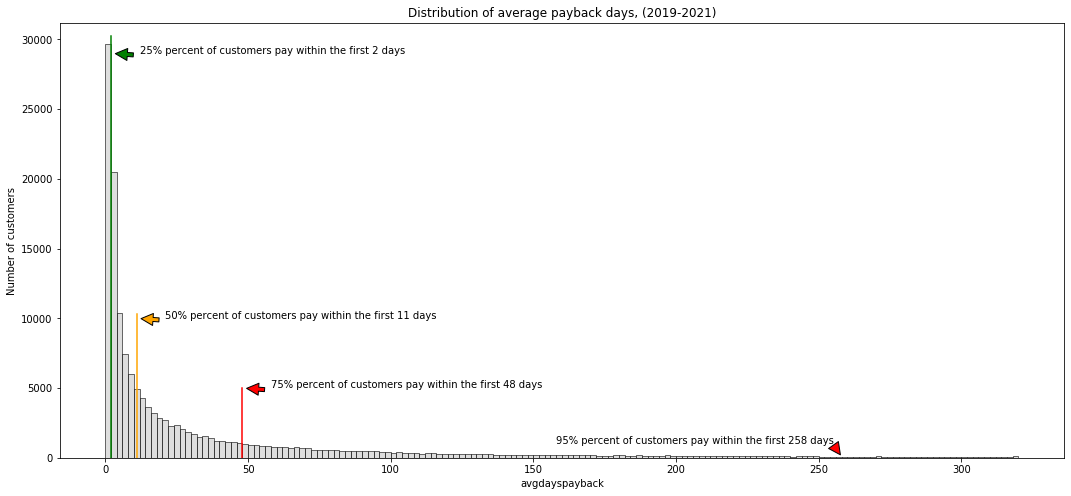

In [13]:
payback_vector = df_model_data['avgdayspayback'][df_model_data['avgdayspayback'] <= 320]
q25, q50, q75, q95 = df_model_data['avgdayspayback'].quantile([.25, .5, .75, .95])
text_left_padding = 10
fig, ax = plt.subplots(figsize = (18, 8))
plt.title("Distribution of average payback days, (2019-2021)")
sns.histplot(payback_vector, binwidth=2, color="lightgrey",ax = ax)
plt.axvline(x=q25, ymin=0, ymax=0.97, color = 'green')
plt.axvline(x=q50, ymin=0, ymax=0.33, color = 'orange')
plt.axvline(x=q75, ymin=0, ymax=0.16, color = 'red')
plt.annotate(f'25% percent of customers pay within the first {np.int(q25)} days', xy=(q25, 29000), xytext=(q25 + text_left_padding, 29000),arrowprops=dict(facecolor='green', shrink=0.15) )
plt.annotate(f'50% percent of customers pay within the first {np.int(q50)} days', xy=(q50, 10000), xytext=(q50 + text_left_padding, 10000),arrowprops=dict(facecolor='orange', shrink=0.15) )
plt.annotate(f'75% percent of customers pay within the first {np.int(q75)} days', xy=(q75, 5000), xytext=(q75+ text_left_padding, 5000),arrowprops=dict(facecolor='red', shrink=0.15) )
plt.annotate(f'95% percent of customers pay within the first {np.int(q95)} days', xy=(q95, 100), xytext=(q95 - 100, 1000),arrowprops=dict(facecolor='red', shrink=0.15) )
plt.ylabel("Number of customers")
plt.savefig('../figures/distribution_average_payback_days.png')
plt.show();

* We consider 15 days as a reasonable period to consider that a customer defaulted on a loan we granted him to complete a transaction. We have the following distribution of customers as seen in the graph below, where `True` are customers that defaulted and `False` are customers that did not defaulted.

* The implications for our scoring model is that we are dealing with an unbalanced dataset. The more days we consider the default period to be, the more unbalanced the dataset will look like. This might have implications in the accuracy of predictions. To change the threshold we need to change the number in of `defaulted_on_average` in the `df_model_data` creation, above.

* At the moment this level of unbalance is ok, we will see later on if we need to apply more sophisticated approaches to correct for unbalanced sets.

* In this regard, the target variable is created based on the historic financial behavior of our customers.

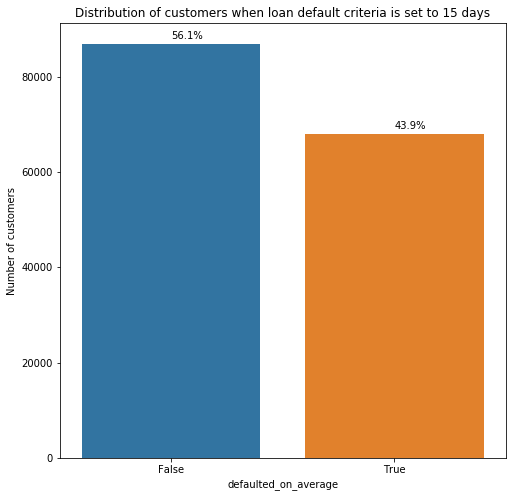

In [14]:
num_not_defaults, num_defaults = df_model_data[['defaulted_on_average']].value_counts().values
pct_not_defaults, pct_defaults = df_model_data[['defaulted_on_average']].value_counts(normalize=True).mul(100).round(1).values

fig, ax = plt.subplots(figsize = (8, 8))
sns.countplot(x="defaulted_on_average", data=df_model_data, ax = ax, )
plt.title("Distribution of customers when loan default criteria is set to 15 days")
plt.annotate(f'{pct_not_defaults}%', xy=(False, num_not_defaults + 1000))
plt.annotate(f'{pct_defaults}%', xy=(True, num_defaults + 1000))
plt.ylabel("Number of customers")
plt.show()

* Considering the above, here is a sample fo the first 10 observations in the dataset.

In [15]:
df_model_data.head(10)

,clienteid,vehicletype,doesstillhasdebit,customerage,sexoid,estadocivilid,estado,nomeplano,pessoa_fisica,totalloans,totalloans_highway,totaloans_parkinglot,totalloans_membershipsubscription,totaltransactions_highway,totatransactions_parkinglot,totaltransactions_membershipsubscription,avaragebalance,avaragerecharge,avgdayspayback,defaulted_on_average
1,62000,Leve,NO,41.0,1.0,2.0,São Paulo,Autocarga,True,27.0,26.0,0.0,0.0,71,4,0,5.11,50.00,155.0,True
6,98642,Leve,YES,64.0,1.0,2.0,São Paulo,Básico,True,1.0,0.0,0.0,0.0,30,0,0,83.47,100.00,19.0,True
9,51812,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,57.0,1.0,2.0,São Paulo,Flex,True,44.0,43.0,0.0,0.0,681,0,36,87.32,93.38,2.0,False
17,145967,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,34.0,1.0,2.0,São Paulo,Autocarga,True,34.0,33.0,0.0,0.0,316,0,0,61.84,107.60,2.0,False
19,205127,Leve,NO,33.0,1.0,1.0,Bahia,Autocarga,True,86.0,58.0,0.0,0.0,823,0,0,147.66,350.00,7.0,False
24,206012,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,62.0,2.0,1.0,São Paulo,Autocarga,True,87.0,87.0,0.0,0.0,464,0,0,29.17,90.33,7.0,False
26,734125,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,40.0,1.0,2.0,Espírito Santo,Abastece Aí,True,1.0,0.0,0.0,1.0,31,0,34,42.81,37.14,44.0,True
30,185494,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,48.0,1.0,2.0,São Paulo,Básico,True,1.0,1.0,0.0,0.0,108,4,0,65.97,69.47,1.0,False
31,350895,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,51.0,1.0,2.0,Rio Grande do Sul,Completo,True,1.0,0.0,0.0,1.0,16,0,15,20.25,100.00,43.0,True
45,561325,Leve,NO,59.0,1.0,2.0,Mato Grosso,Básico,True,5.0,5.0,0.0,0.0,142,0,0,81.00,83.63,29.0,True


---------

## 3. Preprocessing <a class="anchor" id="preprocessing"></a>

In this section we are going to create a machine learning pipeline to preprocess data, so we can leave it in a state that the model can work with. For example: 

- Machine learning models work only with numeric matrices (floats), and so far `df_model_data` has many columns that have integers, text and boolean variables. 

- Moreover, some categorical data have many levels such as `estado`, `doesstillhasdebit`, `nomeplano` and `doesstillhasdebit`, these have to be transformed so that each level has their own category taking values of 0 or 1.

- Some variables such as `customerage` have extreme values such as 120 years old, and we need to impute this with reasonable values.

- Some variables such as `sexoid`, `estadocivilid` and `vehciletype` have NULL values, that have to be replaced with a value for the final matrix.

- Some variables such as `estado` and `nomeplano` have many levels, which are unevenly distributed and this can cause the model to not correctly predict as there are few examples to learn from. 

All these issues have to be addressed programmatically in a systematic way inside a pipeline, so that when new data arrives, it can be transformed to train the model, or when the trained model receives new observations to make new inferences.

### 3.1 Splitting data <a class="anchor" id="splitting_data"></a>

* The ConectCar Scoring model requires to divide data `df_model_data` in three datasets:
 - **Training**: a first subset of the original dataset used to train the model to extract the patterns of the clients that default on a loan and those that do not default.
 - **Validation**: a second subset of the original dataset used to fine tune the hyperparameters of the ML model, until it reaches an acceptable performance.
 - **Test**: a third subset of the original dataset used to compare and select the best performing model.
 
 
* An important question is in which proportions should we split the data. The answer is, we have to experiment. Popular combinations are:
 - 50% training: 25% validation: 25% test
 - 80% training: 10% validation: 10% test
 
 
<img src="../figures/train_test_split.png" alt="Train-Validation-Test Split" class="center"> 
 
* Which combination to use depends on many factors such as how much data you have. If there is plenty, there is not a big issue. The important considerations are that we need to have enough data to train the model so it can learn as much patterns as possible, and that we have plenty of data to provide accurate measures for the validation and test sets. A model trained with a few unrepresentative observations will perform very bad. An evaluation with very few unrepresentative observations can provide misleading performance metrics.


* As each customer in our data is a row, each customer will appear only once in any of the given training, validation or testing datasets. To ensure a good mix, we must shuffle our clients and let randomness break with any unforeseen selection bias.

* Since this is an unbalanced problem, where we have much more customers that do not default on their loans and we have much less customers that do default, we need to ensure to stratify the selection of customers for each dataset. We must ensure within each dataset the same proportion of classes that are seen in real life.

* If we want to ensure reproducibility, we need to set a randomness seed on the split.

* As we have plenty of data, we are going to use a 50% training: 25% validation: 25% test. We are going to implement the split using scikit-learn `train_test_split` (see [documentation](https://scikit-learn.org/stable/modules/cross_validation.html))


In [16]:
from transformers import fun_clean_defaulted_on_average

# Separate the target from the features X, y
y = fun_clean_defaulted_on_average(df_model_data.defaulted_on_average)    # Convert target from boolean to float.
X = df_model_data.drop(columns = 'defaulted_on_average')                  # Remove the target variable from the X features

# Split the data set in training and testing
from sklearn.model_selection import train_test_split
X_train, X_test_full, y_train, y_test_full = train_test_split(
    X, y,                # Provide data inputs X features and y target
    stratify=y,          # Stratify the dataset by the target classes of default (1) and not default (0)
    test_size = .5,      # Split train and full test in 50:50
    random_state = seed  # Set a random seed to ensure reproducibility.
)

# Split the test into validation and testing
X_val, X_test, y_val, y_test = train_test_split(
    X_test_full, y_test_full, 
    stratify=y_test_full, 
    test_size = .5, 
    random_state = seed
)

In [17]:
print("\nRESULTS OF TRAIN-VALIDATION-TEST SPLIT\n")
print("Training set: ")
print(f"- X -> num. rows: {X_train.shape[0]}\tnum. cols: {X_train.shape[1]}")
print(f"- y -> num. rows: {y_train.shape[0]}")
print("\nValidation set: ")
print(f"- X -> num. rows: {X_val.shape[0]}\tnum. cols: {X_val.shape[1]}")
print(f"- y -> num. rows: {y_val.shape[0]}")
print("\nTest set: ")
print(f"- X -> num. rows: {X_test.shape[0]}\tnum. cols: {X_test.shape[1]}")
print(f"- y -> num. rows: {y_test.shape[0]}")


RESULTS OF TRAIN-VALIDATION-TEST SPLIT

Training set: 
- X -> num. rows: 77474	num. cols: 19
- y -> num. rows: 77474

Validation set: 
- X -> num. rows: 38737	num. cols: 19
- y -> num. rows: 38737

Test set: 
- X -> num. rows: 38737	num. cols: 19
- y -> num. rows: 38737


### 3.2 Preprocessing variables for machine learning model

* Lets build the preprocessing component of the pipeline. The purpose is to apply the same transformations to our data each time new observations arrive.

* The whole purpose is to convert all data into numbers that a mathematical model can work with.

* Therefore, each kind of variable numeric or categoric recieves a different treatment.

* It is also common that some variables requiere more than one steps to be cleaned:
    - Imputing missing values.
    - Aggregating categorical variables with large cardinality (many classes)
    - Creating new variables from existing ones, such a years, months, days from datetime timestamps.
    

* All these considerations should be accounted as part of the preprocessing component.

* We leverage pandas and scikit-learn to achieve this.
    - Pandas provides a vast amount of operation functions to transform and clean data.
    - Scikit-learn provides the framework for fitting and transforming data, in a consistent framework for machine learning models.


* A few considerations to understand what is happening in the code below:
    - The input of the entire pipeline are pandas dataframes for X and pandas series for y
    - The output of the preprocessing pipeline is a numpy array without columns.
    - In a later process we extract the column names of existing and new variables, so we can later analyze the results.

* Lets discuss the code implementation:
    
    - We are using a different pipeline for each varaiale.
    - To create a pipeline we use scikit-learn `Pipeline` object (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)). This object allow us to apply many steps to a single variable for instance: first impute data, then apply a user defined function, then apply one hot encoder.
    - To apply user defined functions we define a python function, and in order to use it within the Pipeline object we need to wrap our user defined function inside the `FunctionTransformer` object (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)).
    - All user defined functions for our model were written in a python script `notebooks/transformers.py`. To import the functions to this kernel we use the following line `from transformers import *`. 
    
    - The user defined functions we have are:
    
        + `fun_clean_vehicletype`: imputes missing values as the majority class leve.
        + `fun_clean_customerage`: clips customer age upper limit using the life expectancy in Brazil that is 76 years old.
        + `fun_clean_sexoid`: relabels categories and missing values as the majority class.
        + `fun_clean_estadocivilid`: relabels encoded categories with real names.
        + `fun_clean_estado`: cleans estado and gives the chance to aggregate categories.
        + `fun_clean_nomeplano`: aggregate the main planos
        + `fun_clean_doesstillhasdebit`: relabel categories in a tidy format.
        + `fun_do_noting`: passes the variables as is so we can use them later on in the pipeline.
    - Some scikit learn variables we use are:

        + SimpleImputer: Imputes null values with median values of the training set for that particular variable (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)).
        + OneHotEncoder: Converts a categorical variable with k labels in k columns for each label that is encoded as 0 if value does not exist, and true if it exists (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)).   
        + FunctionTransformer: Allows you to implement user defined functions. (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)).

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from transformers import *

In [19]:
####### DEFINING PREPROCESSING PIPELINES FOR NUMERIC AND CATEGORICAL VARIABLES #######
no_transformation_variables = [
    'totalloans', 'totalloans_highway', 'totaloans_parkinglot', 'totalloans_membershipsubscription', 
    'totaltransactions_highway', 'totatransactions_parkinglot', 'totaltransactions_membershipsubscription',
    'avaragebalance']

pipe_customerage = Pipeline([('ct_customerage', FunctionTransformer(fun_clean_customerage)), ('imputer', SimpleImputer(strategy = 'median'))])
pipe_vehicletype = Pipeline([('ct_vehicletype', FunctionTransformer(fun_clean_vehicletype)), ('one_hot', OneHotEncoder(sparse=True))])
pipe_sexoid = Pipeline([('ct_sexoid', FunctionTransformer(fun_clean_sexoid)), ('one_hot', OneHotEncoder(sparse=True))])
pipe_estadocivilid = Pipeline([('ct_estadocivilid', FunctionTransformer(fun_clean_estadocivilid)), ('one_hot', OneHotEncoder(sparse=True))])
pipe_estado = Pipeline([('ct_estado', FunctionTransformer(fun_clean_estado)), ('one_hot', OneHotEncoder(sparse=True))])
pipe_nomeplano = Pipeline([('ct_nomeplano', FunctionTransformer(fun_clean_nomeplano)), ('one_hot', OneHotEncoder(sparse=True))])
pipe_doesstillhasdebit = Pipeline([('ct_doesstillhasdebit', FunctionTransformer(fun_clean_doesstillhasdebit)), ('one_hot', OneHotEncoder(sparse=True))])
pipe_pessoa_fisica = Pipeline([('one_hot', OneHotEncoder(sparse=True))])
pipe_averagerecharge = Pipeline([('imputer', SimpleImputer(strategy = 'median'))])
pipe_vars_with_no_transformation = Pipeline([('do_nothing', FunctionTransformer(fun_do_noting))])

* Each pipeline will produce an independent matrix, so we need to join them together into a single matrix, and we do that using the `ColumnTransformer` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)).

In [20]:
###### JOINING THE PREPROCESING OF EACH NUMERIC AND CATEGORIC VARIABLE INTO A SINGLE NUMERIC DESIGN MATRIX ######

# Documentation: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn import set_config
set_config(display="diagram")

preprocessor = ColumnTransformer(
    transformers=[
        ('pipe_vars_with_no_transformation', pipe_vars_with_no_transformation, no_transformation_variables),
        ('prep_averagerecharge', pipe_averagerecharge, ['avaragerecharge']),
        ('prep_customerage', pipe_customerage, 'customerage'),
        ('prep_vehicletype', pipe_vehicletype, 'vehicletype'),
        ('prep_sexoid', pipe_sexoid, 'sexoid'),
        ('prep_estadocivilid', pipe_estadocivilid, 'estadocivilid'),
        ('prep_estado', pipe_estado, 'estado'),
        ('prep_nomeplano', pipe_nomeplano, 'nomeplano'),
        ('prep_doesstillhasdebit', pipe_doesstillhasdebit, 'doesstillhasdebit'),
        ('prep_pessoa_fisica', pipe_pessoa_fisica, ['pessoa_fisica'])      
    ],
    n_jobs = -1 # Parallize jobs
)

preprocessor.fit_transform(X_train)

array([[ 6.,  4.,  0., ...,  1.,  0.,  1.],
       [36., 33.,  0., ...,  1.,  0.,  1.],
       [ 3.,  3.,  0., ...,  1.,  0.,  1.],
       ...,
       [ 2.,  0.,  0., ...,  1.,  1.,  0.],
       [ 6.,  6.,  0., ...,  1.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.]])

* What does all this code mean in one diagram. See below, that each variable has a separate pipeline with two steps, first the user defined functions is applied and then a one hot encoder is used. Only `totalloans`, `totalloans_highway`, `totaloans_parkinglot`, `totalloans_membershipsubscription`, `totatransactions_parkinglot`, `avaragebalance` and `avaragerecharge` do not recieve any transformation. 

In [21]:
preprocessor
#X_train_preprocessed = preprocessor.fit_transform(X_train)

ColumnTransformer(n_jobs=-1,
                  transformers=[('pipe_vars_with_no_transformation',
                                 Pipeline(steps=[('do_nothing',
                                                  FunctionTransformer(func=<function fun_do_noting at 0x7fba7846a200>))]),
                                 ['totalloans', 'totalloans_highway',
                                  'totaloans_parkinglot',
                                  'totalloans_membershipsubscription',
                                  'totaltransactions_highway',
                                  'totatransactions_parkinglot',
                                  'totaltransactions_me...
                                                  FunctionTransformer(func=<function fun_clean_nomeplano at 0x7fba7846a0e0>)),
                                                 ('one_hot', OneHotEncoder())]),
                                 'nomeplano'),
                                ('prep_doesstillhasdebit',
                                 Pipeline(steps=[('ct_doesstillhasdebit',
                                                  FunctionTransformer(func=<function fun_clean_doesstillhasdebit at 0x7fba7846a170>)),
                                                 ('one_hot', OneHotEncoder())]),
                                 'doesstillhasdebit'),
                                ('prep_pessoa_fisica',
                                 Pipeline(steps=[('one_hot', OneHotEncoder())]),
                                 ['pessoa_fisica'])])

* Let's apply all the transformations to the `X_train`, `X_val` and `X_test`.
* Notice that first we need to fit the preprocessor. That is beacause the object needs to memorize the information of the `X_train` such as means and standard deviations from the numeric data and the order and names of the categories for the categorical data, so that when new data such as `X_val` and `X_test` arrive it can transform the variables using the same parameters.
* This is a very subtle but critical step, that ensure that our models are protected against data leakage (see [Data Leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning))).

In [22]:
# Fitting and transforming
preprocessor = preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

* Let's see how the transformed design matrix looks like!
* But, before let's recover the names of the variables before showing a sample of the output of the preprocessing stage.

In [23]:
####### RECOVER COLUMN NAMES FROM THE NUMERIC AND CATEGORICAL VARIABLES #######

def get_feature_names():
    '''This function recovers the name of the preprocessed features'''
    feature_names = []
    feature_names.extend(no_transformation_variables)
    feature_names.extend(['avaragerecharge'])
    feature_names.extend(['customerage'])
    feature_names.extend(preprocessor.named_transformers_['prep_vehicletype']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_sexoid']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_estadocivilid']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_estado']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_nomeplano']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_doesstillhasdebit']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_pessoa_fisica'].get_feature_names_out())
    return feature_names

list_feature_names = get_feature_names()

* Let's see the first 20 lines of the X_train_preprocessed

In [24]:
print("Results of the preprocessed X_train")
pd.DataFrame(X_train_preprocessed, columns = list_feature_names).head(20)

Results of the preprocessed X_train


,totalloans,totalloans_highway,totaloans_parkinglot,totalloans_membershipsubscription,totaltransactions_highway,totatransactions_parkinglot,totaltransactions_membershipsubscription,avaragebalance,avaragerecharge,customerage,vehicletype_leve,vehicletype_pesado,sexoid_female,sexoid_male,estadocivilid_married,estadocivilid_other,estadocivilid_single,estado_minas_gerais,estado_other,estado_parana,estado_rio_de_janeiro,estado_rio_grande_do_sul,estado_santa_catarina,estado_sao_paulo,nomeplano_abastece_ai,nomeplano_basico,nomeplano_completo,nomeplano_other,doesstillhasdebit_last_transaction_loan_not_repaid,doesstillhasdebit_last_transaction_loan_repaid,doesstillhasdebit_last_transaction_no_loan,pessoa_fisica_False,pessoa_fisica_True
0,6.0,4.0,0.0,2.0,82.0,0.0,29.0,37.59,49.00,42.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,36.0,33.0,0.0,3.0,1116.0,10.0,70.0,42.90,54.55,36.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3.0,3.0,0.0,0.0,135.0,3.0,0.0,42.63,82.00,27.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,400.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.57,70.66,44.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,0.0,0.0,66.0,0.0,29.0,48.35,58.69,25.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
5,9.0,7.0,0.0,2.0,190.0,0.0,27.0,45.80,52.77,28.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
6,4.0,2.0,2.0,0.0,138.0,3.0,0.0,56.59,82.63,45.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,2.0,2.0,0.0,0.0,83.0,0.0,36.0,44.57,50.00,44.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,5.0,1.0,0.0,4.0,259.0,1.0,24.0,48.12,62.27,37.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,1.0,1.0,0.0,0.0,392.0,0.0,36.0,76.00,54.18,28.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [25]:
pd.DataFrame(X_train_preprocessed, columns = list_feature_names).isna().sum()

totalloans                                            0
totalloans_highway                                    0
totaloans_parkinglot                                  0
totalloans_membershipsubscription                     0
totaltransactions_highway                             0
totatransactions_parkinglot                           0
totaltransactions_membershipsubscription              0
avaragebalance                                        0
avaragerecharge                                       0
customerage                                           0
vehicletype_leve                                      0
vehicletype_pesado                                    0
sexoid_female                                         0
sexoid_male                                           0
estadocivilid_married                                 0
estadocivilid_other                                   0
estadocivilid_single                                  0
estado_minas_gerais                             

* Now that our data is transformed we can use it in an algorithm.

* We are going to save the test data for later analysis as well.

In [26]:
joblib.dump((X_test_preprocessed, y_test, list_feature_names), "../data/preprocessed/test_set.joblib")
s3_client.upload_file("../data/preprocessed/test_set.joblib", bucket_name, "model-data/test_set.joblib")

* We are going to save the preprocessor, if we later only want to use it to predict the scores in section 8.

In [27]:
joblib.dump(preprocessor, "../models/preprocessing_pipeline/preprocessor.joblib")
s3_client.upload_file("../models/preprocessing_pipeline/preprocessor.joblib", bucket_name, "model-preprocessor/preprocessor.joblib")

## 4. Modelling <a class="anchor" id="modelling"></a>

### 4.1 Base model

* Lets create a baseline model to set an initial point to improve the performance of our model and explain how the model arrives to a prediction.
* We are going to use a Decision Tree for its simplicity and interpretability. To learn more about the intuition of how this model works check we can check this [video](https://www.youtube.com/watch?v=7VeUPuFGJHk). To learn more about the implementation in scikit-learn, we can check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).
* We are going to connect our preprocessing steps with the model. See the diagram below.

In [28]:
from sklearn.tree import DecisionTreeClassifier

pipe_dt = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(max_depth = 20, random_state=seed))]
)

* We train the model with the training data, remember that we need to pass the design matrix with the features `X_train`and the labels for each customer `y_train`.
* Notice we use the `fit()` method in our pipeline object `pipe_dt`.
* Depending on the model complexity this process can take some time.

In [29]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipe_vars_with_no_transformation',
                                                  Pipeline(steps=[('do_nothing',
                                                                   FunctionTransformer(func=<function fun_do_noting at 0x7fba7846a200>))]),
                                                  ['totalloans',
                                                   'totalloans_highway',
                                                   'totaloans_parkinglot',
                                                   'totalloans_membershipsubscription',
                                                   'totaltransactions_highway',
                                                   'totatransactions_p...
                                                 ('prep_doesstillhasdebit',
                                                  Pipeline(steps=[('ct_doesstillhasdebit',
                                                                   FunctionTransformer(func=<function fun_clean_doesstillhasdebit at 0x7fba7846a170>)),
                                                                  ('one_hot',
                                                                   OneHotEncoder())]),
                                                  'doesstillhasdebit'),
                                                 ('prep_pessoa_fisica',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['pessoa_fisica'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=20, random_state=42))])

* Let's make some predictions with the validation set of customers `X_val`. 
* Note that we use `predict()` method on the trained pipeline `pipe_dt`, and that we only pass the features of our customers `X_val`.
* Altough we know `y_val`, we are simulating what will happen in real life.

In [30]:
# Save best model
joblib.dump(pipe_dt['classifier'], f'../models/model/base_decision_tree_model.joblib')
s3_client.upload_file("../models/model/base_decision_tree_model.joblib", bucket_name, "best-models/base_decision_tree_model.joblib")

* We can use the model to predict probabilities using the method `predict_proba()` on the trained model. Remember that probabilities range between 0 and 1.

In [31]:
y_val_predicted_proba_dt = pipe_dt.predict_proba(X_val)[: ,1]
# Show first 20 probabilities
print(np.round(y_val_predicted_proba_dt[:20],2))

[1.   0.   0.4  0.2  0.01 0.   1.   0.79 1.   0.   0.   0.36 0.92 0.68
 1.   0.   0.   0.01 0.12 0.33]


* Here is a distribution of the probabilities that our model estimated. We can clearly see two modes, one close to zero that will belong to customers with a low proability to default a loan. On the other hand, the mode close to one, represents the customers with high probabiility to default on a loan.

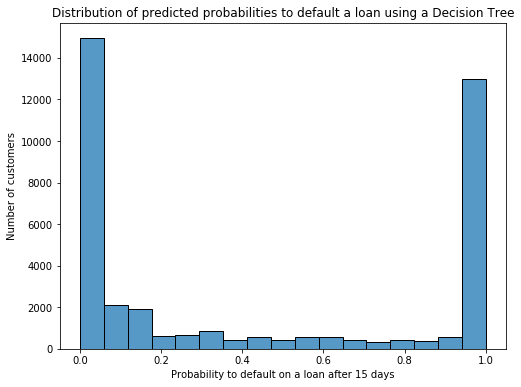

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(y_val_predicted_proba_dt, kde = False, ax = ax)
plt.title("Distribution of predicted probabilities to default a loan using a Decision Tree")
plt.xlabel("Probability to default on a loan after 15 days")
plt.ylabel("Number of customers")
plt.show()

* Also we can use the model to predict the class using the probabilities and a cutting threshold. A common practice is to set the threshold as 0.5, so that  customers with a probability below 0.5 will not default on a loan, and custoemrs with a probability greater than 0.5 will default on the loan. However, 0.5  is not necerarilly the best cutting threshold, it is a business decision.

* Setting a probability greater to 0.5, makes our classification model more strict to identify custoemrs that will default.

* Setting a probability less than 0.5, makes our classifier less strict to identify customers that will default.

* Another way to classify probabilities will be to conduct a cost-benefit analysis, about how much it cost the company to recover the loans.

In [33]:
y_val_predicted_class_dt = [1 if val > 0.5 else 0 for val in pipe_dt.predict_proba(X_val)[: ,1]]
# Show first 20 classes
y_val_predicted_class_dt[:20]

[1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]

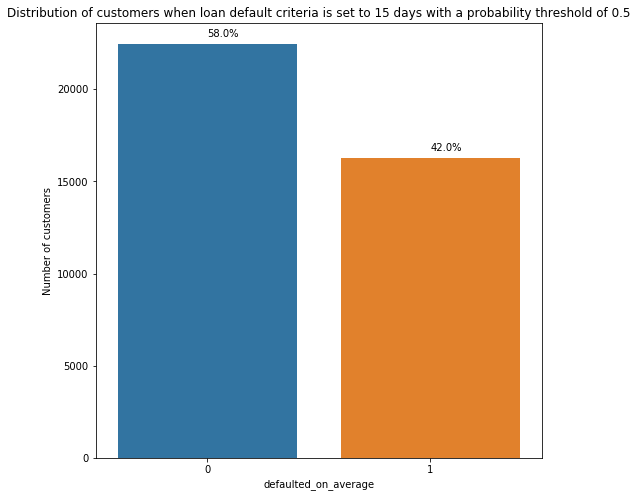

In [34]:
num_not_defaults, num_defaults = pd.DataFrame({'defaulted_on_average':y_val_predicted_class_dt}).value_counts().values
pct_not_defaults, pct_defaults = pd.DataFrame({'defaulted_on_average':y_val_predicted_class_dt}).value_counts(normalize=True).mul(100).round(1).values

fig, ax = plt.subplots(figsize = (8, 8))
sns.countplot(x="defaulted_on_average", data=pd.DataFrame({'defaulted_on_average':y_val_predicted_class_dt}), ax = ax, )
plt.title("Distribution of customers when loan default criteria is set to 15 days with a probability threshold of 0.5")
plt.annotate(f'{pct_not_defaults}%', xy=(False, num_not_defaults + 400))
plt.annotate(f'{pct_defaults}%', xy=(True, num_defaults + 400))
plt.ylabel("Number of customers")
plt.show()

* Here is a summary table for the first 20 customers. 
    - `prob_default` is the probability to default on a loan, and is the score we assign to our customers. 
    - The `pred_class_thr50`, `pred_class_thr25` and `pred_class_thr90` are the classes we can assign to each customer, where 0 means does not default and 1 means default. Each column uses a different probability threshold 0.5, 0.25 and 90, respectively.
    - You can see how the classifier with threshold 0.25 is less strict to classify customers as defaulted, while the classifier with threshold 0.9 is more strict to classify customers as defaulted.

In [35]:
# First 20 customers in the validation set.
(X_val
     .reset_index()
     .rename(columns = {'index' : 'customer_id'})
     .filter(['customer_id'])
     .assign(
         prob_default = np.round(y_val_predicted_proba_dt,2), 
         pred_class_thr50 = [1 if val > 0.5 else 0 for val in pipe_dt.predict_proba(X_val)[: ,1]],
         pred_class_thr25 = [1 if val > 0.25 else 0 for val in pipe_dt.predict_proba(X_val)[: ,1]],
         pred_class_thr90 = [1 if val > 0.9 else 0 for val in pipe_dt.predict_proba(X_val)[: ,1]])
     .head(20)
)

,customer_id,prob_default,pred_class_thr50,pred_class_thr25,pred_class_thr90
0,106845,1.00,1,1,1
1,443225,0.00,0,0,0
2,136764,0.40,0,1,0
3,418409,0.20,0,0,0
4,559998,0.01,0,0,0
5,654311,0.00,0,0,0
6,915333,1.00,1,1,1
7,988936,0.79,1,1,0
8,404715,1.00,1,1,1
9,63890,0.00,0,0,0


### 4.2 Use cases and model evaluation

#### 4.2.1 Use probabilities as the final outcome**

* When we just want to use probabilities, as is the case of the scoring model to grade our customers, we desire that the estimated loan default probabilities are reflective of the true underlying probabilities of the sample. That is, the predicted class probability needs to be well-calibrated. To be well-calibrated, the probabilities must effectively reflect the true likelihood of the event of interest. For example, if the model for a given customer predicts a default on loan probability of 20%, then this value would be well-calibrated if similar types of customers would truly be from that class on average in 1 of 5 samples (20%)

* One way to assess the quality of the class probabilities is using a calibration plot. For a given set of data, this plot shows some measure of the observed probability of an event versus the predicted class probability. One approach for creating this visualization is to score a collection of samples with known outcomes (preferably the validation or test set) using a classification model. The next step is to bin the data into groups based on their class probabilities. For example, a set of bins might be [0, 10%], (10%, 20%], ..., (90%, 100%]. For each bin, determine the observed event rate.  For example, suppose that 50 samples fell into the bin for class probabilities less than 10%, and there was a single event. The midpoint of the bin is 5% and the observed event rate would be 2% . The calibration plot would display the midpoint of the bin on the x-axis and the observed event rate on the y-axis. If the point falls along a 45º line, the model has produced well-calibrated probabilities.

* We can implement the calibration curve using scikit-learn `CalibrationDisplay` object (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibrationDisplay.html)), as seen in the figure below.


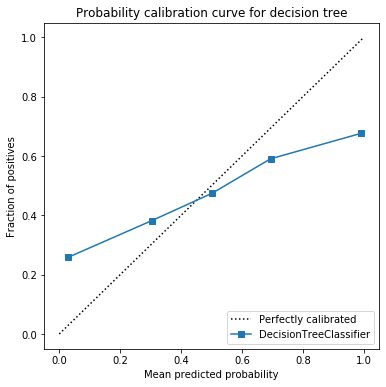

In [36]:
from sklearn.calibration import CalibrationDisplay
fig, ax = plt.subplots(figsize=(6, 6))
calibration_curve_plot = CalibrationDisplay.from_estimator(
    pipe_dt['classifier'], 
    X_val_preprocessed, 
    y_val, ax=ax)
plt.title("Probability calibration curve for decision tree")
plt.show()

* In the plot we can see that for this base model the probabilities deviate from the diagonal line. For the estimate probability ranges between 0 an 0.5 we see that our base model underestimates the true probability samples, on the other hand, in the ranges of estimated probabilities of 0.5 and 1 the model tends to overestimate the true probabilities.

* This behavior can be the result of many reasons. The model needs to be improved with new variables, the model hyperparameters are not the best, the classes are unbalanced.

* When we run the tuning stage, we will see if we can correct for this behavior.

* In case the calibration does not improve we can still run another model on top that will help us correct the probabilities so that they can be better calibrated.


#### 4.2.2 Use predicted classes as final outcome

* When we want to use the predicted classes as our final outcome, we need to make a business decision. What is the cutting threshold we are going to apply to the probabilities to decide whether a customer defaults or does not defaults. For instance, we could say that the threshold is 0.5, if the customer predicted probability lies below 0.5 we assign the class of not defaulting on the loan. On the other hand, if the probability is above 0.5 we assign the class of defaulting on the loan.

* Once we do this we need to evaluate the quality of the class predictions by comparing the true labels vs the predicted labels, to understand how our classifier is working. We can do this with different visualizations and statistics.

##### 4.2.2.1 Confusion matrix

* The confusion matrix lets us summarize the mistakes of our model.
    - False positives (FP): for a customer the true value is not default, but the model predicted default.
    - False negatives (FN): for a customer the true value is default, but the model predicts not defaults.
    - True positives (TP): for a customer that defaults the model correctly predicts defaults.
    - True negatives (TN): for a customer that does not default, the model correctly predicts that he will not default.


* Not all mistakes have the same cost for the business. Therefore, we ideally want that all observations concentrate in the diagonal of not-default-not-default and default-default.

<img src="../figures/confusion_matrix.png" alt="Confusion Matrix" class="center">

* For this base model, using a threshold of 0.5, we have the following confusion matrix. We clearly see that the model predicts correctly most of the customers that do not default. This is not surprising as it is the dominant class. On the other hand, it does not catches all of customers that default.

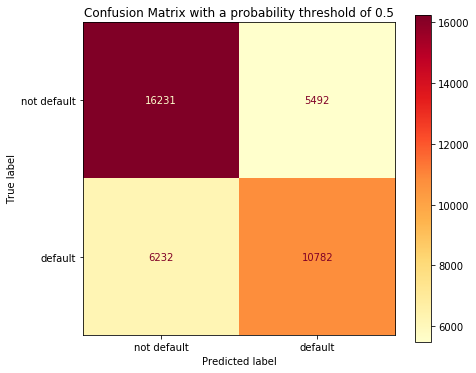

In [37]:
# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

def fun_plot_confusion_matrix(y_true, y_pred):
    (ConfusionMatrixDisplay
         .from_predictions(
             y_true, y_pred, 
             display_labels = ['not default', 'default'], 
             cmap = 'YlOrRd', ax = ax)
    )

fig, ax = plt.subplots(figsize = (7,6))
fun_plot_confusion_matrix(y_val, y_val_predicted_class_dt)
plt.title("Confusion Matrix with a probability threshold of 0.5")
plt.show()

* These misclassification error can be minimized by using better predictors, using more complex models such as Random Forests, Xgboost, LightGBM or CatBoost, choosing better hyperparameters and choosing an approriate probability threshold.

* It is worth mentioning that there is an irreducible error that we will not be able to reduce, unless we have better predictors.

* Lets see how a confusion matrix with diffrent thresholds look like.

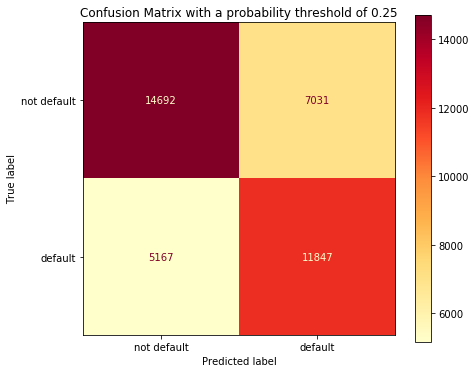

In [38]:
fig, ax = plt.subplots(figsize = (7,6))
fun_plot_confusion_matrix(y_val, [1 if val > 0.25 else 0 for val in pipe_dt.predict_proba(X_val)[: ,1]])
plt.title("Confusion Matrix with a probability threshold of 0.25")
plt.show()

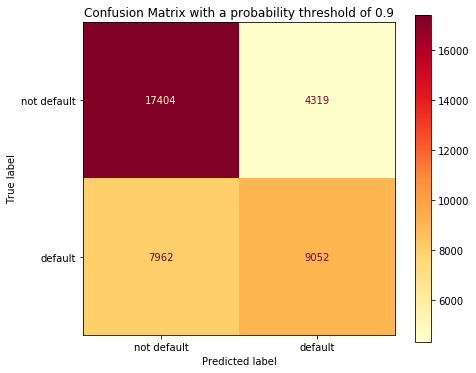

In [39]:
fig, ax = plt.subplots(figsize = (7,6))
fun_plot_confusion_matrix(y_val, [1 if val > 0.9 else 0 for val in pipe_dt.predict_proba(X_val)[: ,1]])
plt.title("Confusion Matrix with a probability threshold of 0.9")
plt.show()

* As we can see there is a trade-off when we move the threshold. 

* Choosing a threshold of 0.25 reduces the false negatives but increases the false positives.

* The opposite happens when choosing a threshold of 0.9, the false positives are reduced and the false negatives increase. 

##### 4.3.2.2 Classification report


* In addition to the confusion matrix we can calculate some statistical metrics to measure the quality of the classifier. These metrics are:

- **Precision**: From the model predictions how many predictions are true defaults. The best value is 1 the worst value is 0.
    
    
$$precision=\frac{TP}{(TP + FP)}$$

- **Recall**: How many of the true default cases can the model predict. The best value is 1 the worst value is 0.
    
$$recall=\frac{TP}{(TP + FN)}$$

- **F1 score**: harmonic mean of recall and precision. The best value is 1 the worst value is 0.
    
$$F1 = 2 * \frac{precision * recall}{(precision + recall)}$$


    
* Which metric matters most depends on the business. If we care more about capturing all custoemrs that will default, recall is a better metric to pay attention. However, if we want that our model predicts correctly, no matter if we do not catch all customers that default, then precision is a better metric. If we want to maintain a balance, we can use the F1 score.

* Lets see how the metrics look like for the threshold of 0.5.

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc 

def fun_classification_report(y_true, y_pred):
    '''This function creates a classification report using recall, precision and F1 score'''
    return pd.DataFrame(
        {'metric': ['precision', 'recall', 'f1'], 
         'value': [precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)]
    }).round(3)

fun_classification_report(y_val, y_val_predicted_class_dt)

,metric,value
0,precision,0.663
1,recall,0.634
2,f1,0.648


* Lets see how the metrics look like for the threshold of 0.25.

In [41]:
fun_classification_report(y_val, [1 if val > 0.25 else 0 for val in pipe_dt.predict_proba(X_val)[: ,1]])

,metric,value
0,precision,0.628
1,recall,0.696
2,f1,0.660


* Lets see how the metrics look like for the threshold of 0.9.

In [42]:
fun_classification_report(y_val, [1 if val > 0.9 else 0 for val in pipe_dt.predict_proba(X_val)[: ,1]])

,metric,value
0,precision,0.677
1,recall,0.532
2,f1,0.596


* Looking at this metrics we can see that a threshold of 0.25 yields better precision and recall metrics as a whole.

##### 4.3.2.3 Precision-Recall Curve

* To show the trade off of precision and recall we can draw a curve using different cutting thresholds.

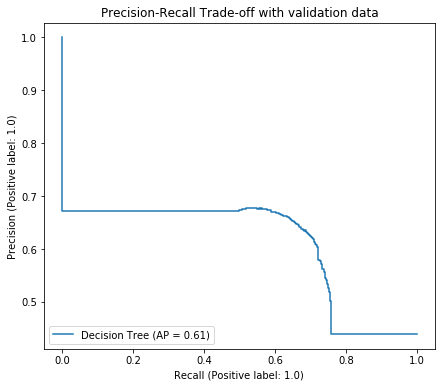

In [43]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(figsize = (7,6))
PrecisionRecallDisplay.from_estimator(
    pipe_dt['classifier'], 
    X_val_preprocessed, 
    y_val, 
    name="Decision Tree",
    ax = ax
)
plt.title("Precision-Recall Trade-off with validation data")
plt.show()

##### 4.3.2.4 ROC curves

* The ROC curve is a graphic that can be used to to determine an effective threshold such that values above the thresold are indicative of a specific event, such as defaulting on a credit. 

* On the y-axis of the curve we have the Sensitivity or the true positive rate (TPR), and on the x axis we have the 1-Specificity or the false positive rate (FPR).

    - TPR: Sensitivity, among the truly positive cases, how much percentage of them are captured in the model correctly.
    
$$TPR = \frac{TP}{(TP + FN)}$$

    - FPR: Among the truly negative cases, how much percentage of them are actually false positive.
    
$$FPR = \frac{FP}{(FP + TN)}$$

* Each point in the graph is our model using a different probability cut off threshold. Thereforethe ROC curve evaluates the class probabilities for the model across a continuum of thresholds.

* The best possible classifier will have 100% sensitivity and specificty, that is a step curve with the vertex located on the top left of the graph. The area under the curve, also known as the ROC AUC score, for a perfect classifier will be 1, the complete graph.

* The worst possible looking classifier is depicted in orange, and the area under the curve is 0.5, half of the graph.

* Our classifier is depicted by the curve color blue, and has a ROC AUC score of 0.69

* This curves reveals that moving the cutting threshold implies a trade off between the true positive rate and the false positive rate.

* It also reveals that we prefer algorithms with AUC score closer to 1.

* About the threshold, when the threshold probability is 1, means we are on the lower left corner of the graph. Setting the threshold to 1 means that we need to be 100% sure that a customer is going to default, that is very difficult so the TPR is zero, and also FPR is zero since we cannot make any mistake with zero positive default cases.

* As we move to the right along the curve, each point means a lower threshold. As we lower the threshold we detect more positive cases and the TPR increases, but also we increase the risk of misclassifying, and this increases the FPR.


* This graph will be very useful to compare more models.

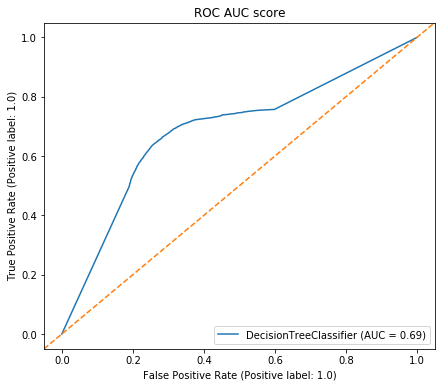

In [44]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize = (7,6))
RocCurveDisplay.from_estimator(pipe_dt['classifier'], X_val_preprocessed, y_val, ax=ax)
plt.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--")
plt.title("ROC AUC score")
plt.show()

* Let's use these first results as a benchmark.

---------

## 5. Tunning <a class="anchor" id="tuning"></a>

* The model above is not the best for two reasons.
    - Its simplicity compromises flexibility that could yield higher performance.
    - It is using default hyperparameters.


* In this section we are going to use more flexible models and we are going to optimize their hyperparameters, to find the combinations that yield the highest performance to improve our models results.


#### 5.1 Random Forest

* Lets train a Random Forest that is an ensemble of n number of decision trees `clf_rf`. You can learn more about its implementation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). To have an intuitive explanation of how the model works see this [video](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ).


* This model has many hyperparameters such as:
    - `n_estimators`: number of decision trees to use in the ensemble.
    - `max_depth`: number of how deep in levels can each of the decision trees can get.
    - `min_samples_split`: The minimum number of samples required to split an internal node.
    - `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
    
    
* The question is what values to use. We need to experiment, and we are going to implement this experimentation with a randomized grid search `param_grid_rf`.
    - It builds a grid of all possible combination of hyperparameters.
    - As these combinations can be plenty, we are going to try some of them randomly `n_iter` using a randomized search `random_search_rf`.
    
    
* A randomized search (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)) allows you to run many models randomly with different combinations of hyperparameters. Later on it will select the best model based on the `scoring` metric. To measure the score of each combination the search uses cross validation `cv`, that trains and validates every model with all the observations of the dataset. It is a mechanism used to protect us against developing models that are good at memorizing and poor with new data (see [documentation](https://scikit-learn.org/stable/modules/cross_validation.html).


* A randomized search can be exhausting, that is why it leverages CPU parallelization `n_jobs`, letting us use all our CPU cores to train models in parallel.


* Notice that `random_search_rf` uses the `fit()` and `predict_proba()` methods.


* The output of `predict_proba()` are going to be the probabilities using the best model found in the random search.


In [45]:
9 * 9 * 9 * 4

2916

In [46]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define model
clf_rf = RandomForestClassifier(n_jobs=-1, verbose = 1, random_state=seed)

# Define hyperparameters grid
param_grid_rf = {
    "n_estimators": [50, 100, 120, 150, 200, 250, 300, 500],
    "max_depth": [3, 4, 5, 6, 7, 8, 15, 25, 30],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 10, 15, 100], 
    "min_samples_leaf": [1, 2, 5, 10]
}

# Define Random Search
random_search_rf = RandomizedSearchCV(
    clf_rf,                 # Model
    param_grid_rf,          # Parameter grid
    n_iter=50,              # Number of samples from the param grid
    scoring='roc_auc',      # Scoring metric
    cv=10,                  # k-folds of cross.validation
    n_jobs=-1,              # CPU parallization
    return_train_score=True, # Return training score
    random_state=seed,
    verbose = 10
)

# Fit all models using random search
random_search_rf.fit(X_train_preprocessed, y_train)

# Save best model
joblib.dump(random_search_rf, '../models/random_search/random_search_decision_tree.joblib')
s3_client.upload_file("../models/random_search/random_search_decision_tree.joblib", bucket_name, "random-search-results/random_search_decision_tree.joblib")

# 20 min average

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.5s finished


CPU times: user 1min 10s, sys: 2.71 s, total: 1min 13s
Wall time: 23min 54s


* Lets see the results of the different models we tried randomly. The scoring metric is the `roc_auc`, that takes a value between 0 and 1. We prefer models with a `roc_auc` closer to 1 in the CV test `mean_test_score`. 

    - Normally `mean_test_score` is worst than the `mean_train_score`, because the model is tested with data the model did not see in training. However, we want them to be close enough.

    - Notice that models with many trees `param_n_estimators` take more time to train `mean_fit_time` than those with less. In that sense we need to measure the costs and benefits of choosing these combinations measured in terms of performance `mean_test_score`.  




In [47]:
(pd.DataFrame(random_search_rf.cv_results_)
     .round(3)
     .sort_values(by = 'rank_test_score')
     .drop(columns = ['std_fit_time', 'mean_score_time', 'std_score_time', 'std_test_score', 'std_train_score', 'params',
                      'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
                      'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score',
                      'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 
                      'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score'
                     ])
)

,mean_fit_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,mean_test_score,rank_test_score,mean_train_score
47,67.388,500,10,10,25,0.839,1,0.901
11,63.164,500,3,2,15,0.839,2,0.917
49,54.113,500,2,1,15,0.839,3,0.930
29,38.300,300,6,10,25,0.839,4,0.901
10,21.239,150,7,5,30,0.839,5,0.940
40,30.518,250,4,10,15,0.839,6,0.880
14,30.342,250,3,10,15,0.839,6,0.880
26,24.028,200,2,10,15,0.839,8,0.880
4,11.758,100,4,10,15,0.838,9,0.880
45,6.310,50,5,5,30,0.838,10,0.939


* Lets save the model in case we want to come back to the code, but we want to skip the training process that can take considerable time and resources. We are going to save the model in the repository `models` directory and also we are going to upload it to S3. 
    - We recover the best model using the `best_estimator_` attribute in the random search object `random_search_rf`.
    - The way we save a machine learning model is using the `joblib` package, that serializes the Python object.



In [48]:
# Save best model
best_clf_rf = random_search_rf.best_estimator_
joblib.dump(best_clf_rf, '../models/model/best_random_forest_model.joblib')
s3_client.upload_file("../models/model/best_random_forest_model.joblib", bucket_name, "best-models/best_random_forest_model.joblib")

In [49]:
# Load best model
best_clf_rf = joblib.load(f'../models/model/best_random_forest_model.joblib')

* Lets make the probability predictions.

In [50]:
# Predict the scoring proababilities using the best model.
y_val_pred_proba_rf = best_clf_rf.predict_proba(X_val_preprocessed)
y_test_pred_proba_rf = best_clf_rf.predict_proba(X_test_preprocessed)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.7s finished


In [51]:
from sklearn.metrics import roc_auc_score, f1_score
#random_search_cat
roc_auc_score(y_val, y_val_pred_proba_rf[:, 1])

0.8405329792204346

In [52]:
f1_score(y_val, y_val_pred_proba_rf[:, 1] > 0.5)

0.721086799711469

#### Xgboost

- Now lets try an Xgboost model that is a state of the art algorithm. It is based on decision trees but also leverages [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting). If you want to learn at high level how this model works you can check this [link](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/). For an inutitive expalanation of how xgboost works, take a look at these videos:

    + [Xgboost - Regression (1 of 4)](https://www.youtube.com/watch?v=OtD8wVaFm6E)    
    + [Xgboost - Classification Details (2 of 4)](https://www.youtube.com/watch?v=8b1JEDvenQU)
    + [Xgboost - Mathematical Details (3 of 4)](https://www.youtube.com/watch?v=ZVFeW798-2I)
    + [Xgboost - Crazy Cool Optimizations (4 of 4)](https://www.youtube.com/watch?v=oRrKeUCEbq8)  



- The xgboost has many more hyperparameters that allow us to control the complexity of the model and therefore likely produce better results. Below are the hyperparameters we are going to tune. To see the complete list of hyperparameters, their definitions and the implementation in python check the [Scikit-Learn API documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn).

    - `eta`: Float, boosting learning rate
    - `gamma`: Float, minimum loss reduction required to make a further partition on a leaf node of the tree.
    - `n_estimators`: Integer, number of gradient boosted trees. Equivalent to number of boosting rounds.
    - `max_depth`: Integer, maximum tree depth for base learners.
    - `min_child_weight`: Float, minimum number of observations that should be in a child node.
    - `subsample`: Float, subsample ratio of the training obervations.
    - `colsample_bytree`: Float, subsample ratio of columns when constructing each tree.
    - `lambda`: Float, L2 regularization term on weights.
    - `alpha`: Float, L1 regularization term on weights..


In [53]:
%%time
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define model
clf_xgb = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric='mlogloss',
    tree_method = "hist",
    #tree_method='gpu_hist', # Uncomment if using an instance with GPU
    random_state=seed)

# Define hyperparameters grid
param_grid_xgb = {
    "eta": [0.01, 0.015, 0.025, 0.05, 0.1],
    "gamma": [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    "n_estimators": [50, 100, 120, 150, 200, 250, 300, 500],
    "max_depth": [3, 4, 5, 6, 7, 8, 15, 25, 30],
    "min_child_weight": [1, 3, 5, 7], 
    "subsample": [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "colsample_bytree": [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "lambda": [0.01, 0.1, 0.5, 1, 10, 100],
    "alpha": [0.01, 0.1, 0.5, 1, 10, 100],
}

# Define Random Search
random_search_xgb = RandomizedSearchCV(
    clf_xgb,                # Model
    param_grid_xgb,         # Parameter grid
    n_iter=50,              # Number of samples from the param grid
    scoring='roc_auc',      # Scoring metric
    cv=10,                  # k-folds of cross.validation
    n_jobs=-1,              # CPU parallization
    return_train_score=True, # Return training score
    random_state=seed,
    verbose = 2
)

# Fit all models using random search
random_search_xgb.fit(X_train_preprocessed, y_train)

# Save best model
joblib.dump(random_search_xgb, '../models/random_search/random_search_xgb.joblib')
s3_client.upload_file("../models/random_search/random_search_xgb.joblib", bucket_name, "random-search-results/random_search_xgb.joblib")

# 30 min average

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


CPU times: user 29 s, sys: 3.69 s, total: 32.6 s
Wall time: 30min 23s


* We can see that in general the XGboost outperforms the RandomForest.

In [54]:
(pd.DataFrame(random_search_xgb.cv_results_)
     .round(3)
     .sort_values(by = 'rank_test_score')
     .drop(columns = ['std_fit_time', 'mean_score_time', 'std_score_time', 'std_test_score', 'std_train_score', 'params',
                      'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
                      'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score',
                      'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 
                      'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score'
                     ])
)

,mean_fit_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_lambda,param_gamma,param_eta,param_colsample_bytree,param_alpha,mean_test_score,rank_test_score,mean_train_score
0,35.370,1,200,5,25,10,0.05,0.05,0.8,10,0.842,1,0.898
8,44.575,0.5,500,3,6,100,1,0.05,1,0.5,0.841,2,0.859
4,17.264,1,200,5,6,1,0.7,0.05,0.4,10,0.840,3,0.851
2,71.629,0.5,500,3,30,100,0.1,0.1,0.8,10,0.840,4,0.894
38,33.390,0.2,200,7,25,0.1,0.1,0.015,0.7,0.5,0.840,5,0.869
18,22.938,0.2,300,1,5,0.1,0.1,0.05,0.9,0.5,0.840,6,0.856
20,26.975,0.9,300,1,6,10,0.5,0.015,1,0.01,0.838,7,0.848
47,55.598,1,200,7,25,0.01,0.3,0.025,0.6,0.01,0.837,8,0.970
42,73.555,0.7,250,1,15,0.5,0.05,0.025,0.9,1,0.837,9,0.983
33,44.468,0.1,300,3,15,0.01,0.1,0.015,0.4,0.1,0.836,10,0.871


In [55]:
# Predict the scoring proababilities using the best model.
y_val_pred_proba_xgb = random_search_xgb.predict_proba(X_val_preprocessed)
y_test_pred_proba_xgb = random_search_xgb.predict_proba(X_test_preprocessed)

In [56]:
# Save best model
best_clf_xgb = random_search_xgb.best_estimator_
joblib.dump(best_clf_xgb, f'../models/model/best_xgboost_model.joblib')
s3_client.upload_file("../models/model/best_xgboost_model.joblib", bucket_name, "best-models/best_xgboost_model.joblib")

In [57]:
# Load best model
best_clf_xgb = joblib.load(f'../models/model/best_xgboost_model.joblib')

* Lets make the probability predictions.

In [58]:
# Predict the scoring proababilities using the best model.
y_val_pred_proba_xgb = best_clf_xgb.predict_proba(X_val_preprocessed)
y_test_pred_proba_xgb = best_clf_xgb.predict_proba(X_test_preprocessed)

In [59]:
from sklearn.metrics import roc_auc_score, f1_score
#random_search_cat
roc_auc_score(y_val, y_val_pred_proba_xgb[:, 1])

0.843317781937609

In [60]:
f1_score(y_val, y_val_pred_proba_xgb[:, 1] > 0.5)

0.7229743991798089

#### 5.2 LightGBM

- Now lets try a LightGBM model that is a state of the art algorithm faster than less taxing in memory than XGboost. It is based on decision trees also. If you want to learn at high level how this model works you can check this [link](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html). 

- LightGBM has also many hyperparameters to control the complexity of the model. We are going to tune the following hyperparamenters.

    - `n_estimators`: Integer, number of boosted trees to fit.
    - `max_depth`: Integer, maximum tree depth for base learners
    - `min_child_weight`: Integer, minimum sum of observations weight needed in a child leaf.
    - `subsample`: Float, subsample ratio of the training observations.
    - `colsample_bytree`: Float, subsample ratio of columns when constructing each tree.
    - `reg_lambda`: Float, L2 regularization term on weights.
    - `reg_alpha`: Float, L1 regularization term on weights.

In [61]:
%%time
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb


# Define model
clf_lgb = lgb.LGBMClassifier(n_jobs=-1, random_state=seed)

# Define hyperparameters grid
param_grid_lgbm = {
    "n_estimators": [50, 100, 120, 150, 200, 250, 300, 500],
    "max_depth": [3, 4, 5, 6, 7, 8, 15, 25, 30],
    "min_child_weight": [1, 2, 3, 4, 5, 6, 7], 
    "subsample": [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "colsample_bytree": [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "reg_lambda": [0.01, 0.1, 0.5, 1, 10, 100, 1000],
    "reg_alpha": [0.01, 0.1, 0.5, 1, 10, 100, 1000],
}

# Define Random Search
random_search_lgbm = RandomizedSearchCV(
    clf_lgb,                # Model
    param_grid_lgbm,         # Parameter grid
    n_iter=50,              # Number of samples from the param grid
    scoring='roc_auc',      # Scoring metric
    cv=10,                  # k-folds of cross.validation
    n_jobs=-1,              # CPU parallization
    return_train_score=True, # Return training score
    random_state=seed,
    verbose=2
)

# Fit all models using random search
random_search_lgbm.fit(X_train_preprocessed, y_train)

# Save best model
joblib.dump(random_search_lgbm, '../models/random_search/random_search_lgbm.joblib')
s3_client.upload_file("../models/random_search/random_search_lgbm.joblib", bucket_name, "random-search-results/random_search_lgbm.joblib")

# 4 minutes average

Fitting 10 folds for each of 50 candidates, totalling 500 fits
CPU times: user 13.1 s, sys: 691 ms, total: 13.8 s
Wall time: 15min 26s


* We can see that the performance `mean_test_score` is close to the Xgboost but the training time `mean_fit_time` is fastest.

In [69]:
(pd.DataFrame(random_search_lgbm.cv_results_)
     .round(3)
     .sort_values(by = 'rank_test_score')
     .drop(columns = ['std_fit_time', 'mean_score_time', 'std_score_time', 'std_test_score', 'std_train_score', 'params',
                      'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
                      'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score',
                      'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 
                      'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score'
                     ])
)

,mean_fit_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,param_max_depth,param_colsample_bytree,mean_test_score,rank_test_score,mean_train_score
8,23.626,1,0.1,0.1,300,5,30,0.6,0.842,1,0.880
26,17.809,0.2,1,0.01,250,4,8,0.7,0.842,2,0.872
46,11.764,0.5,1,1,150,6,15,0.8,0.841,3,0.863
30,37.042,0.9,10,0.5,500,1,15,0.7,0.841,4,0.886
27,13.714,0.6,0.5,0.5,150,1,8,0.5,0.841,5,0.860
33,21.841,0.4,0.01,1,300,4,8,0.8,0.841,6,0.879
10,14.487,1,0.1,0.5,150,4,7,0.6,0.841,7,0.861
16,13.461,1,0.01,10,150,2,8,0.7,0.841,8,0.856
32,16.667,1,0.01,10,250,4,5,0.8,0.841,9,0.858
34,12.203,0.5,0.5,10,150,1,7,0.6,0.841,10,0.855


In [70]:
# Predict the scoring proababilities using the best model.
y_val_pred_proba_lgbm = random_search_lgbm.predict_proba(X_val_preprocessed)
y_test_pred_proba_lgbm = random_search_lgbm.predict_proba(X_test_preprocessed)

In [71]:
# Save best model
best_clf_lgbm = random_search_lgbm.best_estimator_
joblib.dump(best_clf_lgbm, f'../models/model/best_lgbm_model.joblib')
s3_client.upload_file("../models/model/best_lgbm_model.joblib", bucket_name, "best-models/best_lgbm_model.joblib")

In [72]:
# Load best model
best_clf_lgbm = joblib.load(f'../models/model/best_lgbm_model.joblib')

* Lets make the probability predictions.

In [73]:
# Predict the scoring proababilities using the best model.
y_val_pred_proba_lgbm = best_clf_lgbm.predict_proba(X_val_preprocessed)
y_test_pred_proba_lgbm = best_clf_lgbm.predict_proba(X_test_preprocessed)

In [74]:
from sklearn.metrics import roc_auc_score, f1_score
#random_search_cat
roc_auc_score(y_val, y_val_pred_proba_lgbm[:, 1])

0.8426734809557361

In [75]:
f1_score(y_val, y_val_pred_proba_lgbm[:, 1] > 0.5)

0.7219647264190694

#### 5.3 CatBoost

- Now lets try a CatBoost another state of the art model based on gradient boosting. If you want to learn at high level how this model works you can check this [link](https://catboost.ai/). 

- Again, Catboost has many hyperparameters to tune, we are only going to optimize for the following:

    + `n_estimators`: Integer, number of trees
    + `learning_rate`: Float, this setting is used for reducing the gradient step. It affects the overall time of training: the smaller the value, the more iterations are required for training.
    + `depth`: The maximum depth of the trees. In most cases, the optimal depth ranges from 4 to 10.
    + `l2_leaf_reg`: Positive integer, coefficient at the L2 regularization term of the cost function.
    
    
- To learn more about how to optimize this model, check the [documentation](https://catboost.ai/en/docs/concepts/parameter-tuning)

In [76]:
%%time
from catboost import CatBoostClassifier

# Define model
clf_cat = CatBoostClassifier(thread_count = -1, random_state=seed, verbose=False)
#    "loss_function": ['Logloss'],
# random_state=seed

# Define hyperparameters grid
param_grid_cat = { 
    "n_estimators": [50, 100, 120, 150, 200, 250, 300, 500],
    "learning_rate": [0.01, 0.015, 0.025, 0.05, 0.1],
    "depth": [3, 4, 5, 6, 7, 8, 9, 10, 15],
    "l2_leaf_reg": [0.01, 0.1, 1, 10, 100, 1000]
}

# Define Random Search
random_search_cat = RandomizedSearchCV(
    clf_cat,                # Model
    param_grid_cat,         # Parameter grid
    n_iter=50,              # Number of samples from the param grid
    scoring='roc_auc',      # Scoring metric
    cv=10,                  # k-folds of cross.validation
    n_jobs=-1,              # CPU parallization
    return_train_score=True, # Return training score
    random_state=seed,
    verbose = 3
)

# Fit all models using random search
random_search_cat.fit(X_train_preprocessed, y_train)

# Save best model
joblib.dump(random_search_cat, '../models/random_search/random_search_catboost.joblib')
s3_client.upload_file("../models/random_search/random_search_catboost.joblib", bucket_name, "random-search-results/random_search_catboost.joblib")

# 5 hours average

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


CPU times: user 8min 29s, sys: 4min 10s, total: 12min 39s
Wall time: 4h 47min 35s


* We can see that the performance `mean_test_score` is close to the Xgboost but the training time `mean_fit_time` is fastest.

In [84]:
(pd.DataFrame(random_search_cat.cv_results_)
     .round(3)
     .sort_values(by = 'rank_test_score')
     .drop(columns = ['std_fit_time', 'mean_score_time', 'std_score_time', 'std_test_score', 'std_train_score', 'params',
                      'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
                      'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score',
                      'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 
                      'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score'
                     ])
)

,mean_fit_time,param_n_estimators,param_learning_rate,param_l2_leaf_reg,param_depth,mean_test_score,rank_test_score,mean_train_score
9,1111.692,250,0.1,1000,15,0.840,1,0.856
41,80.139,250,0.05,0.01,9,0.840,2,0.879
35,68.245,150,0.05,0.1,10,0.840,3,0.873
22,153.039,500,0.015,0.01,9,0.840,4,0.865
5,82.987,200,0.025,1,10,0.839,5,0.858
44,25.497,100,0.1,100,8,0.839,6,0.846
25,36.414,120,0.05,10,9,0.839,7,0.850
3,22.761,100,0.1,10,7,0.839,8,0.847
37,1485.931,300,0.025,1,15,0.839,9,0.952
2,491.957,100,0.1,10,15,0.838,10,0.924


In [85]:
# Predict the scoring proababilities using the best model.
y_val_pred_proba_cat = random_search_cat.predict_proba(X_val_preprocessed)
y_test_pred_proba_cat = random_search_cat.predict_proba(X_test_preprocessed)

In [86]:
from sklearn.metrics import roc_auc_score, f1_score
#random_search_cat
roc_auc_score(y_val, y_val_pred_proba_cat[:, 1])

0.8410434783822716

In [87]:
f1_score(y_val, y_val_pred_proba_cat[:, 1] > 0.5)

0.7221989089383131

In [88]:
# Save best model
best_clf_cat = random_search_cat.best_estimator_
joblib.dump(best_clf_cat, f'../models/model/best_catboost_model.joblib')
s3_client.upload_file("../models/model/best_catboost_model.joblib", bucket_name, "best-models/best_catboost_model.joblib")


In [89]:
# Load best model
best_clf_cat = joblib.load(f'../models/model/best_catboost_model.joblib')


* Lets make the probability predictions.

In [90]:
# Predict the scoring proababilities using the best model.
y_val_pred_proba_cat = best_clf_cat.predict_proba(X_val_preprocessed)
y_test_pred_proba_cat = best_clf_cat.predict_proba(X_test_preprocessed)

#### 5.4 Logit

- Lets train a different model not based on tree models, according to the literature the most common algorithm used in credit risk analysis is a logit model, that is a linear model, that also performs very well. In comparison with the tree-based models, a logit is a model with more structure, meaning it is less flexible.

- We are going to implement a Logistic regression with Lasso penalization (`penalty=l2`), that can help us regularize the model and eventually eliminate variables that are not helping to improve the model. If you want to learn more about the intuition of this algorithm see this [video](https://www.youtube.com/watch?v=yIYKR4sgzI8). If you want to learn more about the implementation of the model please check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

- The hyperparameters we are going to tune in this model is:

    + `C`: Float, it is the Lasso penalization hyperparameter. Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.
   
- To implement this model, we need to slightly modify our preprocessing to avoid multicollinearity among predictors in the one hot encoder and also standardizing the numeric variables.

    + For `totalloans`, `totalloans_highway`, `totaloans_parkinglot`, `totalloans_membershipsubscription`, `totatransactions_parkinglot`, `avaragebalance`, `avaragerecharge` we need to standarize their values, as all of them are in different scales, and the algotihm is sensible to variable scales. After transformation all variables will have `mean=0` and `standard deviation=0`. 
    
    + For the rest of the categorical variables, we need to drop one level within each categorical variable to avoid multiclonality, we are not losing information. For instance in sexoid we drop female level. So instead of having a male and a female, two columns, after one hot encoding, now we will have just male. Male is encoded as 0 and 1, where 1 means men, and zero means female. This is why we do not lose information. We achieve this by adding the argument `drop='first'`to `OneHotEncoder()`.
    
- We implement these changes in the pipeline and rerun the other parts as in the rest of the models.


In [91]:
####### DEFINING PREPROCESSING PIPELINES FOR NUMERIC AND CATEGORICAL VARIABLES #######
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from transformers import *

no_transformation_variables = [
    'totalloans', 'totalloans_highway', 'totaloans_parkinglot', 'totalloans_membershipsubscription', 
    'totaltransactions_highway', 'totatransactions_parkinglot', 'totaltransactions_membershipsubscription',
    'avaragebalance']

pipe_customerage = Pipeline([('ct_customerage', FunctionTransformer(fun_clean_customerage)), ('imputer', SimpleImputer(strategy = 'median'))])
pipe_vehicletype = Pipeline([('ct_vehicletype', FunctionTransformer(fun_clean_vehicletype)), ('one_hot', OneHotEncoder(sparse=True, drop='first'))])
pipe_sexoid = Pipeline([('ct_sexoid', FunctionTransformer(fun_clean_sexoid)), ('one_hot', OneHotEncoder(sparse=True, drop='first'))])
pipe_estadocivilid = Pipeline([('ct_estadocivilid', FunctionTransformer(fun_clean_estadocivilid)), ('one_hot', OneHotEncoder(sparse=True, drop='first'))])
pipe_estado = Pipeline([('ct_estado', FunctionTransformer(fun_clean_estado)), ('one_hot', OneHotEncoder(sparse=True, drop='first'))])
pipe_nomeplano = Pipeline([('ct_nomeplano', FunctionTransformer(fun_clean_nomeplano)), ('one_hot', OneHotEncoder(sparse=True, drop='first'))])
pipe_doesstillhasdebit = Pipeline([('ct_doesstillhasdebit', FunctionTransformer(fun_clean_doesstillhasdebit)), ('one_hot', OneHotEncoder(sparse=True, drop='first'))])
pipe_pessoa_fisica = Pipeline([('one_hot', OneHotEncoder(sparse=True, drop='first'))])
pipe_numeric = Pipeline([('scaler', StandardScaler())])
pipe_averagerecharge = Pipeline([('imputer', SimpleImputer(strategy = 'median'))])


* All these steps are the same as the rest, no changes were applied.

In [92]:
###### JOINING THE PREPROCESING OF EACH NUMERIC AND CATEGORIC VARIABLE INTO A SINGLE NUMERIC DESIGN MATRIX ######

# Documentation: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn import set_config
set_config(display="diagram")

preprocessor_logit = ColumnTransformer(
    transformers=[
        ('pipe_numeric', pipe_numeric, no_transformation_variables),
        ('prep_averagerecharge', pipe_averagerecharge, ['avaragerecharge']), 
        ('prep_customerage', pipe_customerage, 'customerage'),
        ('prep_vehicletype', pipe_vehicletype, 'vehicletype'),
        ('prep_sexoid', pipe_sexoid, 'sexoid'),
        ('prep_estadocivilid', pipe_estadocivilid, 'estadocivilid'),
        ('prep_estado', pipe_estado, 'estado'),
        ('prep_nomeplano', pipe_nomeplano, 'nomeplano'),
        ('prep_doesstillhasdebit', pipe_doesstillhasdebit, 'doesstillhasdebit'),
        ('prep_pessoa_fisica', pipe_pessoa_fisica, ['pessoa_fisica'])      
    ],
    n_jobs = -1
)


# Fitting and transforming
preprocessor_logit.fit(X_train)
X_train_preprocessed_logit = preprocessor_logit.transform(X_train)
X_val_preprocessed_logit = preprocessor_logit.transform(X_val)
X_test_preprocessed_logit = preprocessor_logit.transform(X_test)


####### RECOVER COLUMN NAMES FROM THE NUMERIC AND CATEGORICAL VARIABLES #######

def get_feature_names(preprocessor):
    '''This function recovers the name of the preprocessed features'''
    feature_names = []
    feature_names.extend(no_transformation_variables)
    feature_names.extend(['avaragerecharge'])
    feature_names.extend(['customerage'])
    feature_names.extend(preprocessor.named_transformers_['prep_vehicletype']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_sexoid']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_estadocivilid']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_estado']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_nomeplano']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_doesstillhasdebit']['one_hot'].get_feature_names_out())
    feature_names.extend(preprocessor.named_transformers_['prep_pessoa_fisica'].get_feature_names_out())
    return feature_names

list_feature_names_logit = get_feature_names(preprocessor_logit)

In [93]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
clf_logit = LogisticRegression(penalty = 'l2', solver = 'saga', max_iter=8000, verbose=2, tol=0.001, n_jobs=-1)

# Define hyperparameters grid
param_grid_logit = { 
    "C": [0.001, 0.01, 0.1, 1]
}

# Define Random Search
random_search_logit = RandomizedSearchCV(
    clf_logit,              # Model
    param_grid_logit,       # Parameter grid
    n_iter=4,              # Number of samples from the param grid
    scoring='roc_auc',      # Scoring metric
    cv=10,                  # k-folds of cross.validation
    n_jobs=-1,               # CPU parallization
    return_train_score=True, # Return training score
    random_state=seed,
    verbose=3
)

# Fit all models using random search
random_search_logit.fit(X_train_preprocessed_logit, y_train)

# Save best model
joblib.dump(random_search_logit, '../models/random_search/random_search_logit.joblib')
s3_client.upload_file("../models/random_search/random_search_logit.joblib", bucket_name, "random-search-results/random_search_logit.joblib")


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 990 epochs took 40 seconds
CPU times: user 39.9 s, sys: 53.1 ms, total: 40 s
Wall time: 5min 36s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.7s finished


In [94]:
random_search_logit = joblib.load('../models/random_search/random_search_logit.joblib')


In [95]:
(pd.DataFrame(random_search_logit.cv_results_)
     .round(3)
     .sort_values(by = 'rank_test_score')
     .drop(columns = ['std_fit_time', 'mean_score_time', 'std_score_time', 'std_test_score', 'std_train_score', 'params',
                      'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
                      'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score',
                      'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 
                      'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score'
                     ])
)

,mean_fit_time,param_C,mean_test_score,rank_test_score,mean_train_score
3,57.824,1,0.556,1,0.556
2,58.371,0.1,0.556,2,0.556
1,58.902,0.01,0.556,3,0.556
0,59.090,0.001,0.556,4,0.556


In [96]:
# Predict the scoring proababilities using the best model.
y_val_pred_proba_logit = random_search_logit.predict_proba(X_val_preprocessed_logit)
y_test_pred_proba_logit = random_search_logit.predict_proba(X_test_preprocessed_logit)


In [97]:
# Save best model
best_clf_logit = random_search_logit.best_estimator_
joblib.dump(best_clf_logit, f'../models/model/best_logit_model.joblib')
s3_client.upload_file("../models/model/best_logit_model.joblib", bucket_name, "best-models/best_logit_model.joblib")

In [98]:
from sklearn.metrics import roc_auc_score, f1_score
#random_search_cat
roc_auc_score(y_val, y_val_pred_proba_logit[:, 1])

0.5570723982661222

In [99]:
f1_score(y_val, y_val_pred_proba_logit[:, 1] > 0.5)


0.00129191379411592

In [124]:
# Load best model
#best_clf_logit = joblib.load(f'../models/model/best_logit_model.joblib')

* Enough training, as you can see models fitting is resource consuming in time and computation. 


---------

## 6. Evaluation <a class="anchor" id="evaluation"></a>

- Now lets compare how our models performed, and select the best option.
- We are going to evaluate our models using the customers in the test data `X_test` and `y_test`. This is data that the model has not seen in fitting and tunning.
- **IMPORTANT**: If we want to run the code of this section without training again the models, we need to load the saved versions.

In [103]:
# Load base model
base_model = joblib.load(f'../models/model/base_decision_tree_model.joblib')
## Load best model
#best_clf_rf = joblib.load(f'../models/model/best_random_forest_model.joblib')
# Load best model
#best_clf_xgb = joblib.load(f'../models/model/best_xgboost_model.joblib')
# Load best model
best_clf_lgb = joblib.load(f'../models/model/best_lgbm_model.joblib')
# Load best model
#best_clf_cat = joblib.load(f'../models/model/best_catboost_model.joblib')
## Load best model
#best_clf_logit = joblib.load(f'../models/model/best_logit_model.joblib')


### 6.1 ROC Curves

* The ROC curves are a good way to compare our different models. The graph below shows the ROC curve and the area under the curve (AUC). 
* The better models are the ones that their AUC are close to 1.
* An AUC close to 0.5 is as good as a random classification.
* From the graph we can see that tree based models perform better. Most of them have a a ROC AUC score of 80%. Not bad, for an MVP, this can further be improved with better variables, a better feature engineering, and a better understanding of our customers behavior.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.7s finished


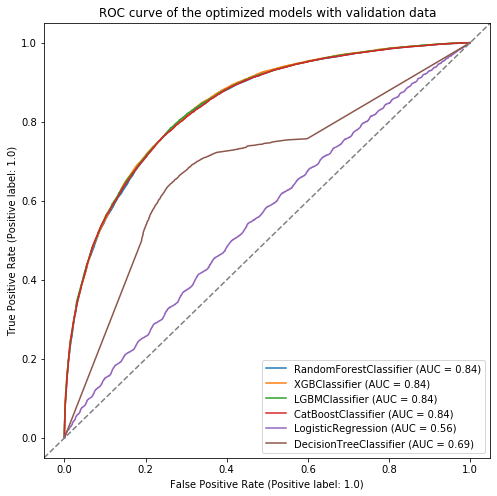

In [104]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(8, 8))
roc_curves_plot = RocCurveDisplay.from_estimator(best_clf_rf, X_val_preprocessed, y_val, ax=ax)
RocCurveDisplay.from_estimator(best_clf_xgb, X_val_preprocessed, y_val, ax=ax)
RocCurveDisplay.from_estimator(best_clf_lgb, X_val_preprocessed, y_val, ax=ax)
RocCurveDisplay.from_estimator(best_clf_cat, X_val_preprocessed, y_val, ax=ax)
RocCurveDisplay.from_estimator(best_clf_logit, X_val_preprocessed_logit, y_val, ax=ax)
RocCurveDisplay.from_estimator(base_model, X_val_preprocessed, y_val, ax=ax)
plt.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color = 'grey')
plt.title("ROC curve of the optimized models with validation data")
plt.show()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.0s finished


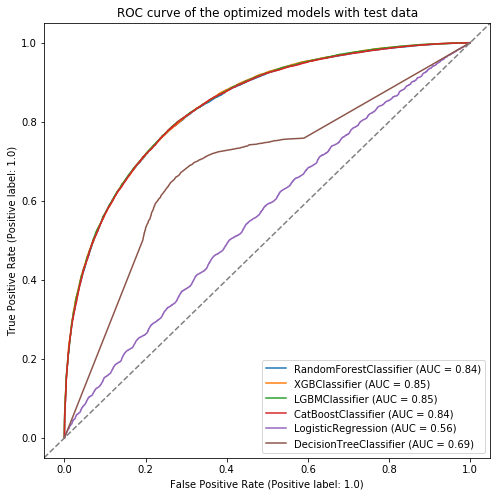

In [105]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(8, 8))
roc_curves_plot = RocCurveDisplay.from_estimator(best_clf_rf, X_test_preprocessed, y_test, ax=ax)
RocCurveDisplay.from_estimator(best_clf_xgb, X_test_preprocessed, y_test, ax=ax)
RocCurveDisplay.from_estimator(best_clf_lgb, X_test_preprocessed, y_test, ax=ax)
RocCurveDisplay.from_estimator(best_clf_cat, X_test_preprocessed, y_test, ax=ax)
RocCurveDisplay.from_estimator(best_clf_logit, X_test_preprocessed_logit, y_test, ax=ax)
RocCurveDisplay.from_estimator(base_model, X_test_preprocessed, y_test, ax=ax)
plt.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color = 'grey')
plt.title("ROC curve of the optimized models with test data")
plt.show()

#### 6.2 Probability calibrations

* From the calibration curves we can see that the tree based models are very well callibrated as they are lying in the perfectly callibrated curve.

* The implications of this result are that we can use the predicted probabilities as the true probabilities of the sample.

* For instance customers that have a predicted probability around 80%, their true labels are also 80%.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.8s finished


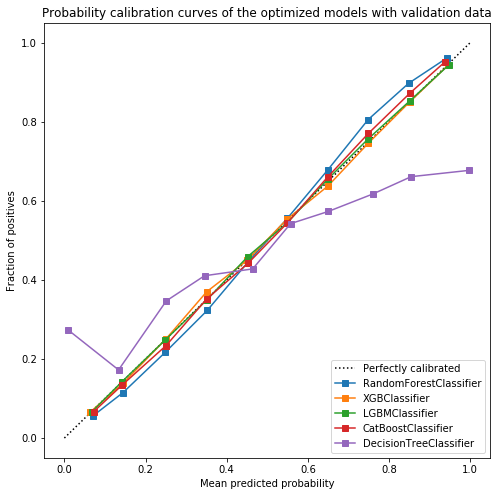

In [108]:
from sklearn.calibration import CalibrationDisplay
fig, ax = plt.subplots(figsize=(8, 8))
calibration_curve_plot = CalibrationDisplay.from_estimator(best_clf_rf, X_val_preprocessed, y_val, ax=ax, n_bins = 10)
CalibrationDisplay.from_estimator(best_clf_xgb, X_val_preprocessed, y_val, ax=ax, n_bins = 10)
CalibrationDisplay.from_estimator(best_clf_lgb, X_val_preprocessed, y_val, ax=ax, n_bins = 10)
CalibrationDisplay.from_estimator(best_clf_cat, X_val_preprocessed, y_val, ax=ax, n_bins = 10)
#CalibrationDisplay.from_estimator(best_clf_logit, X_val_preprocessed_logit, y_val, ax=ax, n_bins = 10)
CalibrationDisplay.from_estimator(base_model, X_val_preprocessed, y_val, ax=ax, n_bins = 10)
plt.title("Probability calibration curves of the optimized models with validation data")
plt.show()

In [ ]:
from sklearn.calibration import CalibrationDisplay
fig, ax = plt.subplots(figsize=(8, 8))
calibration_curve_plot = CalibrationDisplay.from_estimator(best_clf_rf, X_test_preprocessed, y_test, ax=ax, n_bins = 10)
CalibrationDisplay.from_estimator(best_clf_xgb, X_test_preprocessed, y_test, ax=ax, n_bins = 10)
CalibrationDisplay.from_estimator(best_clf_lgb, X_test_preprocessed, y_test, ax=ax, n_bins = 10)
CalibrationDisplay.from_estimator(best_clf_cat, X_test_preprocessed, y_test, ax=ax, n_bins = 10)
#CalibrationDisplay.from_estimator(best_clf_logit, X_test_preprocessed_logit, y_test, ax=ax, n_bins = 10)
CalibrationDisplay.from_estimator(base_model, X_test_preprocessed, y_test, ax=ax, n_bins = 10)
plt.title("Probability calibration curves of the optimized models with test data")
plt.savefig("../figures/probability_calibration_curve_test_set.png")
plt.show()

### 6.3 Classification report

* In case we are interested in using the classes lets review the classification reports.

* From the classification report we can look at the precision and recall, the good news is that precision and recall a very close and have a high score. The table is ordered in descending order based on the f1 score that is the harmonic mean of the precision and recall. Based on this metric we will choose the LightGBM as the best model.

* Lets interpret the metrics of the best model in the validation set, we are going to make the assumption that the probability threshold cutoff is in 0.5:

    - Precision: Our model correctly predicts 70% of the predictions as customers that defaulted the loan.
    - Recall: Our model is able to detect 70% of all the customers that defaulted on a loan.
    - F1: score is an index between 0 and 100% that summarizes the precision and recall to be around 70%.



In [109]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def fun_calculate_classification_metrics(model, X, y, thr = 0.5):
    '''Create a classification report with precision, recall and f1 score.'''
    def fun_create_classes_based_on_prob_threshold(model, X, thr):
        '''Creates the classes based on the probability cutting threshold.'''
        y_pred_proba = model.predict_proba(X)[:, 1] 
        return np.where(y_pred_proba > thr, 1, 0)

    y_class_pred = fun_create_classes_based_on_prob_threshold(model, X, thr)
    
    return {
        'model': model.__class__.__name__, 
        'threshold': thr,
        'precision': np.round(precision_score(y, y_class_pred),4),
        'recall': np.round(recall_score(y, y_class_pred),4),
        'f1': np.round(f1_score(y, y_class_pred),4),
        'roc_auc': np.round(roc_auc_score(y, model.predict_proba(X)[:, 1]),4)
    }

def fun_table_discrimination_threshold(model, X, threshold_range = np.arange(0.1,1,0.1)):
    '''Returns a dataframe with the classification report using many probability thresholds'''
    list_results = []
    for threshold in threshold_range:
        result = fun_calculate_classification_metrics(model, X, y_val, thr = threshold)
        list_results.append(result)
    return pd.DataFrame(list_results)

def fun_classification_report_with_optimal_threshold(tbl_results):
    '''
    Returns the classification report with the optimal threshold that
    maximizes the f1 score, which yields the best balance between 
    precision and recall.
    '''
    return tbl_results.iloc[tbl_results.f1.idxmax()].to_frame().T

def fun_plot_discrimination_threshold(tbl_results):
    '''
    Plots the f1, precion and recall for a model using different probability thresholds.
    It also shows the optimal threshold that maximizes the f1 score, which yields the 
    best balance between precision and recall.
    '''
    max_f1_score = tbl_results.f1.idxmax()
    optim_threshold = np.round(tbl_results.iloc[max_f1_score]['threshold'],3)
    model = tbl_results.iloc[max_f1_score]['model']
    
    fig, ax = plt.subplots(figsize =(8,6))
    tbl_results.plot(x = 'threshold', y = 'f1', ax = ax)
    tbl_results.plot(x = 'threshold', y = 'recall', ax = ax)
    tbl_results.plot(x = 'threshold', y = 'precision', ax = ax)
    plt.vlines(x = optim_threshold, ymin= 0, ymax=1, linestyles='dotted', label = f'optimal threshold = {optim_threshold}')
    plt.legend()
    plt.title(f'{model} with different probability thresholds.\nF1 score is maximized with {optim_threshold} threshold.')
    plt.show()

#### 6.3.1 DecisionTreeClassifier


In [110]:
tbl_classification_report = fun_table_discrimination_threshold(base_model, X_val_preprocessed, threshold_range = np.arange(0.1,1,0.05))
tbl_classification_report

,model,threshold,precision,recall,f1,roc_auc
0,DecisionTreeClassifier,0.10,0.5626,0.7357,0.6376,0.6861
1,DecisionTreeClassifier,0.15,0.6086,0.7157,0.6578,0.6861
2,DecisionTreeClassifier,0.20,0.6191,0.7072,0.6602,0.6861
3,DecisionTreeClassifier,0.25,0.6276,0.6963,0.6601,0.6861
4,DecisionTreeClassifier,0.30,0.6339,0.6867,0.6593,0.6861
5,DecisionTreeClassifier,0.35,0.6411,0.6736,0.6570,0.6861
6,DecisionTreeClassifier,0.40,0.6498,0.6572,0.6535,0.6861
7,DecisionTreeClassifier,0.45,0.6534,0.6499,0.6517,0.6861
8,DecisionTreeClassifier,0.50,0.6625,0.6337,0.6478,0.6861
9,DecisionTreeClassifier,0.55,0.6632,0.6300,0.6462,0.6861


In [111]:
clf_report_base = fun_classification_report_with_optimal_threshold(tbl_classification_report)
clf_report_base

,model,threshold,precision,recall,f1,roc_auc
2,DecisionTreeClassifier,0.2,0.6191,0.7072,0.6602,0.6861


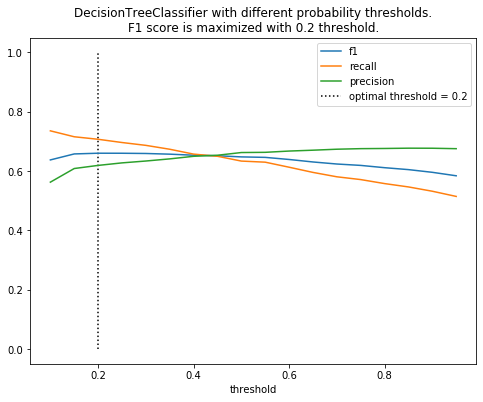

In [112]:
fun_plot_discrimination_threshold(tbl_classification_report)

#### 6.3.2 RandomForestClassifier


In [113]:
tbl_classification_report = fun_table_discrimination_threshold(best_clf_rf, X_val_preprocessed, threshold_range = np.arange(0.1,1,0.05))
tbl_classification_report

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.6s finished
[

,model,threshold,precision,recall,f1,roc_auc
0,RandomForestClassifier,0.10,0.4880,0.9856,0.6528,0.8405
1,RandomForestClassifier,0.15,0.5311,0.9642,0.6849,0.8405
2,RandomForestClassifier,0.20,0.5660,0.9455,0.7081,0.8405
3,RandomForestClassifier,0.25,0.5925,0.9244,0.7221,0.8405
4,RandomForestClassifier,0.30,0.6162,0.9000,0.7315,0.8405
5,RandomForestClassifier,0.35,0.6441,0.8671,0.7392,0.8405
6,RandomForestClassifier,0.40,0.6747,0.8216,0.7409,0.8405
7,RandomForestClassifier,0.45,0.7042,0.7717,0.7364,0.8405
8,RandomForestClassifier,0.50,0.7379,0.7051,0.7211,0.8405
9,RandomForestClassifier,0.55,0.7704,0.6312,0.6939,0.8405


In [114]:
clf_report_rf =fun_classification_report_with_optimal_threshold(tbl_classification_report)
clf_report_rf

,model,threshold,precision,recall,f1,roc_auc
6,RandomForestClassifier,0.4,0.6747,0.8216,0.7409,0.8405


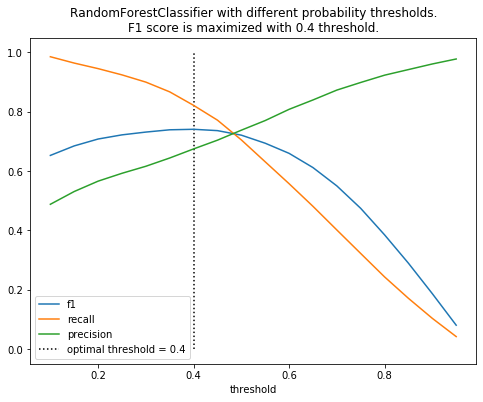

In [115]:
fun_plot_discrimination_threshold(tbl_classification_report)

#### 6.3.3 XGBClassifier


In [116]:
tbl_classification_report = fun_table_discrimination_threshold(best_clf_xgb, X_val_preprocessed, threshold_range = np.arange(0.1,1,0.05))
tbl_classification_report

,model,threshold,precision,recall,f1,roc_auc
0,XGBClassifier,0.10,0.5134,0.9753,0.6727,0.8433
1,XGBClassifier,0.15,0.5558,0.9531,0.7022,0.8433
2,XGBClassifier,0.20,0.5886,0.9314,0.7214,0.8433
3,XGBClassifier,0.25,0.6133,0.9080,0.7321,0.8433
4,XGBClassifier,0.30,0.6388,0.8805,0.7404,0.8433
5,XGBClassifier,0.35,0.6639,0.8452,0.7437,0.8433
6,XGBClassifier,0.40,0.6882,0.8012,0.7404,0.8433
7,XGBClassifier,0.45,0.7144,0.7546,0.7340,0.8433
8,XGBClassifier,0.50,0.7423,0.7046,0.7230,0.8433
9,XGBClassifier,0.55,0.7712,0.6493,0.7050,0.8433


In [117]:
clf_report_xgb = fun_classification_report_with_optimal_threshold(tbl_classification_report)
clf_report_xgb

,model,threshold,precision,recall,f1,roc_auc
5,XGBClassifier,0.35,0.6639,0.8452,0.7437,0.8433


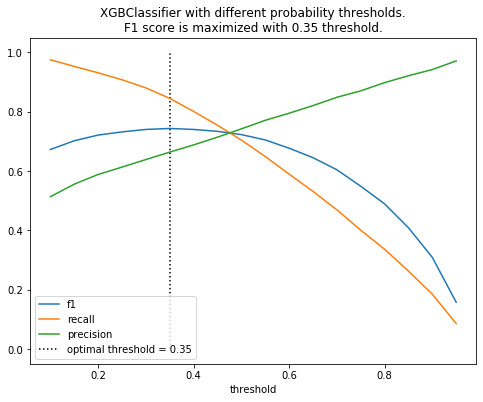

In [118]:
fun_plot_discrimination_threshold(tbl_classification_report)

#### 6.3.4 CatBoostClassifier

In [119]:
tbl_classification_report = fun_table_discrimination_threshold(best_clf_cat, X_val_preprocessed, threshold_range = np.arange(0.1,1,0.05))
tbl_classification_report

,model,threshold,precision,recall,f1,roc_auc
0,CatBoostClassifier,0.10,0.5053,0.9771,0.6661,0.841
1,CatBoostClassifier,0.15,0.5520,0.9533,0.6992,0.841
2,CatBoostClassifier,0.20,0.5819,0.9331,0.7168,0.841
3,CatBoostClassifier,0.25,0.6046,0.9128,0.7274,0.841
4,CatBoostClassifier,0.30,0.6293,0.8882,0.7366,0.841
5,CatBoostClassifier,0.35,0.6520,0.8541,0.7395,0.841
6,CatBoostClassifier,0.40,0.6781,0.8137,0.7397,0.841
7,CatBoostClassifier,0.45,0.7065,0.7688,0.7363,0.841
8,CatBoostClassifier,0.50,0.7369,0.7081,0.7222,0.841
9,CatBoostClassifier,0.55,0.7695,0.6415,0.6997,0.841


In [120]:
clf_report_cat = fun_classification_report_with_optimal_threshold(tbl_classification_report)
clf_report_cat

,model,threshold,precision,recall,f1,roc_auc
6,CatBoostClassifier,0.4,0.6781,0.8137,0.7397,0.841


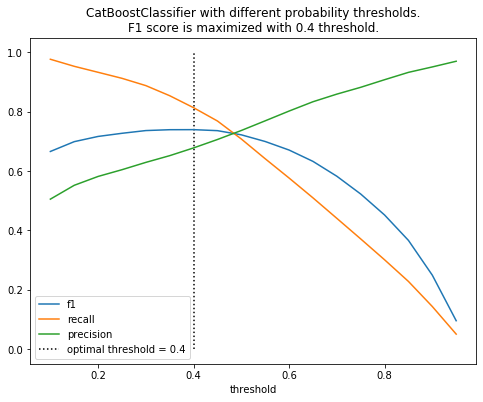

In [121]:
fun_plot_discrimination_threshold(tbl_classification_report)

#### 6.3.5 LGBMClassifier

In [122]:
tbl_classification_report = fun_table_discrimination_threshold(best_clf_lgb, X_val_preprocessed, threshold_range = np.arange(0.1,1,0.05))
tbl_classification_report

,model,threshold,precision,recall,f1,roc_auc
0,LGBMClassifier,0.10,0.5087,0.9764,0.6689,0.8427
1,LGBMClassifier,0.15,0.5568,0.9500,0.7021,0.8427
2,LGBMClassifier,0.20,0.5886,0.9275,0.7202,0.8427
3,LGBMClassifier,0.25,0.6143,0.9054,0.7320,0.8427
4,LGBMClassifier,0.30,0.6372,0.8785,0.7387,0.8427
5,LGBMClassifier,0.35,0.6605,0.8472,0.7423,0.8427
6,LGBMClassifier,0.40,0.6860,0.8087,0.7423,0.8427
7,LGBMClassifier,0.45,0.7104,0.7620,0.7353,0.8427
8,LGBMClassifier,0.50,0.7398,0.7049,0.7220,0.8427
9,LGBMClassifier,0.55,0.7706,0.6456,0.7026,0.8427


In [123]:
clf_report_lgbm = fun_classification_report_with_optimal_threshold(tbl_classification_report)
clf_report_lgbm

,model,threshold,precision,recall,f1,roc_auc
5,LGBMClassifier,0.35,0.6605,0.8472,0.7423,0.8427


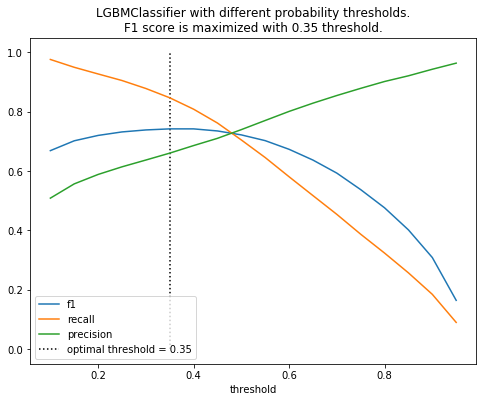

In [124]:
fun_plot_discrimination_threshold(tbl_classification_report)


#### 6.3.5 Summary of the best models

In [125]:
tbl_summary = (
    pd.concat([
        clf_report_base,
        clf_report_rf,
        clf_report_xgb,
        clf_report_cat,
        clf_report_lgbm,
    ], ignore_index=True)
    .set_index('model')
    .astype(np.number)
    .sort_values(by = 'f1', ascending = False)
    .round(4))
tbl_summary

,threshold,precision,recall,f1,roc_auc
model,,,,,
XGBClassifier,0.35,0.6639,0.8452,0.7437,0.8433
LGBMClassifier,0.35,0.6605,0.8472,0.7423,0.8427
RandomForestClassifier,0.40,0.6747,0.8216,0.7409,0.8405
CatBoostClassifier,0.40,0.6781,0.8137,0.7397,0.8410
DecisionTreeClassifier,0.20,0.6191,0.7072,0.6602,0.6861


* The best model is the LGBM because it is almost has the same result as the XGBoost but it is also trained in the least time.

### 6.4 Precision-Recall Curves

- Below we can see the precision-recall curves from all models. Looking at the tree based models we can see that if we want to ensure a precision in our predictions of 90% we need to sacrifice the recall to 10%. That means that such classifiers will only capture 10% of the customers that defaulted on a loan. That is a big price to pay.

- If we want a model with a recall of 90% we need reduce the precision of the predictions to 50%. Also a very high price to pay.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.8s finished


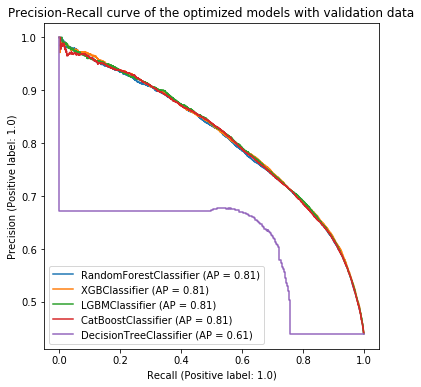

In [128]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(figsize=(6, 6))
precision_recall_plot = PrecisionRecallDisplay.from_estimator(best_clf_rf, X_val_preprocessed, y_val, ax=ax)
PrecisionRecallDisplay.from_estimator(best_clf_xgb, X_val_preprocessed, y_val, ax=ax)
PrecisionRecallDisplay.from_estimator(best_clf_lgb, X_val_preprocessed, y_val, ax=ax)
PrecisionRecallDisplay.from_estimator(best_clf_cat, X_val_preprocessed, y_val, ax=ax)
PrecisionRecallDisplay.from_estimator(base_model, X_val_preprocessed, y_val, ax=ax)
#PrecisionRecallDisplay.from_estimator(best_clf_logit, X_val_preprocessed_logit, y_val, ax=ax)
plt.title("Precision-Recall curve of the optimized models with validation data")
plt.show()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished


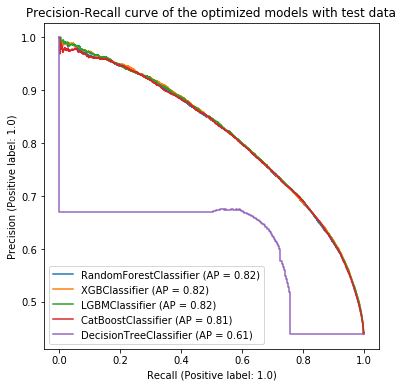

In [129]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(figsize=(6, 6))
precision_recall_plot = PrecisionRecallDisplay.from_estimator(best_clf_rf, X_test_preprocessed, y_test, ax=ax)
PrecisionRecallDisplay.from_estimator(best_clf_xgb, X_test_preprocessed, y_test, ax=ax)
PrecisionRecallDisplay.from_estimator(best_clf_lgb, X_test_preprocessed, y_test, ax=ax)
PrecisionRecallDisplay.from_estimator(best_clf_cat, X_test_preprocessed, y_test, ax=ax)
PrecisionRecallDisplay.from_estimator(base_model, X_test_preprocessed, y_test, ax=ax)
#PrecisionRecallDisplay.from_estimator(best_clf_logit, X_test_preprocessed_logit, y_test, ax=ax)
plt.title("Precision-Recall curve of the optimized models with test data")
plt.show()

---------

## 7. Calculate scores for all customers <a class="anchor" id="scores"></a>

* **Important**: Make sure to run the setup and import libraries in  [section 1.4.](#setup), loading data section 2 and split data in section 3.1 and data preprocessing in 3.2.

* Preprocess all customer data

In [130]:
# Predict scores
X_all_customers = preprocessor.fit_transform(X)

In [131]:
pd.DataFrame(X_all_customers, columns = list_feature_names)

,totalloans,totalloans_highway,totaloans_parkinglot,totalloans_membershipsubscription,totaltransactions_highway,totatransactions_parkinglot,totaltransactions_membershipsubscription,avaragebalance,avaragerecharge,customerage,vehicletype_leve,vehicletype_pesado,sexoid_female,sexoid_male,estadocivilid_married,estadocivilid_other,estadocivilid_single,estado_minas_gerais,estado_other,estado_parana,estado_rio_de_janeiro,estado_rio_grande_do_sul,estado_santa_catarina,estado_sao_paulo,nomeplano_abastece_ai,nomeplano_basico,nomeplano_completo,nomeplano_other,doesstillhasdebit_last_transaction_loan_not_repaid,doesstillhasdebit_last_transaction_loan_repaid,doesstillhasdebit_last_transaction_no_loan,pessoa_fisica_False,pessoa_fisica_True
0,27.0,26.0,0.0,0.0,71.0,4.0,0.0,5.11,50.00,41.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,30.0,0.0,0.0,83.47,100.00,64.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,44.0,43.0,0.0,0.0,681.0,0.0,36.0,87.32,93.38,57.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,34.0,33.0,0.0,0.0,316.0,0.0,0.0,61.84,107.60,34.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,86.0,58.0,0.0,0.0,823.0,0.0,0.0,147.66,350.00,33.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154943,6.0,5.0,0.0,1.0,59.0,0.0,7.0,35.57,80.00,31.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
154944,4.0,1.0,0.0,2.0,2.0,0.0,5.0,13.76,50.00,36.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
154945,27.0,27.0,0.0,0.0,3937.0,28.0,56.0,689.92,487.84,39.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
154946,1.0,0.0,0.0,1.0,18.0,0.0,1.0,50.81,100.00,34.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


* Predict with best model

In [132]:
# Load best model
best_clf_lgb = joblib.load(f'../models/model/best_lgbm_model.joblib')
# Predict with best model (prob of defaulting after 15 days)
customer_scores = best_clf_lgb.predict_proba(X_all_customers)[:, 1]

* Create customer dataframe.

In [133]:
tbl_scores = (
    X[['clienteid']]
        .assign(score = np.round(customer_scores,4),
                model = 'lgbm_model',
                date_inference = str(pd.to_datetime('now'))[:10])
)

* Show first 50 customers

In [134]:
tbl_scores.head(50)

,clienteid,score,model,date_inference
1,62000,0.3721,lgbm_model,2021-12-30
6,98642,0.6964,lgbm_model,2021-12-30
9,51812,0.0376,lgbm_model,2021-12-30
17,145967,0.1646,lgbm_model,2021-12-30
19,205127,0.0992,lgbm_model,2021-12-30
24,206012,0.2799,lgbm_model,2021-12-30
26,734125,0.5409,lgbm_model,2021-12-30
30,185494,0.5026,lgbm_model,2021-12-30
31,350895,0.5134,lgbm_model,2021-12-30
45,561325,0.4605,lgbm_model,2021-12-30


* Show last 50 customers

In [135]:
tbl_scores.tail(50)

,clienteid,score,model,date_inference
1014718,955059,0.6226,lgbm_model,2021-12-30
1014733,1041977,0.2632,lgbm_model,2021-12-30
1014734,1092308,0.9425,lgbm_model,2021-12-30
1014757,1306531,0.3621,lgbm_model,2021-12-30
1014767,32253,0.5025,lgbm_model,2021-12-30
1014768,936505,0.9704,lgbm_model,2021-12-30
1014770,982376,0.6663,lgbm_model,2021-12-30
1014775,1208145,0.4893,lgbm_model,2021-12-30
1014776,968012,0.2612,lgbm_model,2021-12-30
1014791,1225086,0.9733,lgbm_model,2021-12-30


In [136]:
tbl_scores.dtypes

clienteid           int64
score             float64
model              object
date_inference     object
dtype: object

* Save scores in sagemaker storage.

In [137]:
tbl_scores.to_csv('../data/scores/conectcar_scores.csv', index = False)

* We download the conectcar scores to S3

In [138]:
s3_client.upload_file("../data/scores/conectcar_scores.csv", bucket_name, "model-output/conectcar_scores.csv")

* We upload the scores to redshift into the schema `cntcar_ds_work` as `v03_customer_scores` table. 

* Notice that if the table already exists the scores are replaced.

* There are two methods to achieve these:

    - 1) `pd.to_sql`: This method uploads the pandas dataframe to redshift. This method is very convenient but it makes a row by row insertion, therefore, the process takes **1 hour 10 minutes** to finish. We implemented this as a first iteration, but given the results we will use a more efficient method.
    


In [8]:
#%%time
#tbl_scores = pd.read_csv('../data/scores/conectcar_scores.csv')
#print(f"Uploading ConectCar scores for {tbl_scores.shape[0]} customers that requested at least one loan in the period 2019-2021.\n")
#tbl_scores.to_sql('v03_customer_scores', con = engine, schema = "cntcar_ds_work",  index=False, if_exists='replace', method='multi')
#print("Scores uploaded")

Uploading ConectCar scores for 154948 customers that requested at least one loan in the period 2019-2021.

Scores uploaded
CPU times: user 18.5 s, sys: 6.26 s, total: 24.8 s
Wall time: 1h 11min 15s


   - 2) `COPY`: Use sqlalchemy connection to Redshift and use the SQL `COPY` command. This is the most efficient method to upload data to RedShift, this process takes only **1.61 seconds** to upload the scores table. Notice that this method requires that we copy the file directly from S3 bucket-key `model-output/conectcar_scores.csv`. Also notice that we require to indicate the IAM ROLE `arn:aws:iam::564512845791:role/sdlf-engineering-AWSRedshiftRol` that has permissions to write to RedShift. Before executing this command make sure that the `engine` for Redshift is created in section [2. Loading data](#loading_data).
    


In [ ]:
%%time
print(f"Uploading ConectCar scores for customers that requested at least one loan in the period 2019-2021.\n")
conn = engine.connect()
sql_query = """
    DROP TABLE IF EXISTS cntcar_ds_work.v03_customer_scores;
    CREATE TABLE cntcar_ds_work.v03_customer_scores
    (
        clienteid VARCHAR, 
        score FLOAT, 
        model VARCHAR, 
        date_inference VARCHAR
    );
    COPY cntcar_ds_work.v03_customer_scores
    FROM 's3://cntcar-dlk-us-east-2-135212681908-artifacts/model-output/conectcar_scores.csv'
    IAM_ROLE 'arn:aws:iam::564512845791:role/sdlf-engineering-AWSRedshiftRole'
    CSV QUOTE AS '"'
    ACCEPTINVCHARS AS ' ' 
    IGNOREHEADER AS 1
"""
conn.execute(sql_query)
conn.close()
print("Scores uploaded")

## 8.Model interpretability <a class="anchor" id="interpretability"></a>

### 8.1 Introduction

* In this section we are going to dive deep into how our best model works.
* We are going to grab the best model we built and explain how the model arrived to the predictions.
* To achieve this we are going to use an aggregate approach using the test data, and also we are going to show on a customer case basis as well.
* We are going to use a state-of-the-art tool called SHAP values to explain the predictions (see this [documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html) and also this [documentation](https://github.com/slundberg/shap)).

#### Disclaimer!

* A subtle but critical distinction is that an explanation of how the model works does not imply we are providing a causal explanation of what causes a probability to increase.
* Our machine learning model does everything that it can to optimize mathematical the best probabilities it can, based on the quantity and available data.
* To provide a causal explanation about the behavior of probabilities we need to do experimentation and use a different set of statistical tools.

### 8.2 Let's load the best model and the test data



* **Important**: Make sure to run the setup and import libraries in  [section 1.4.](#setup)

In [139]:
import shap

* If we do not want to rerun the training for each of our models. Lets load the best model.

In [140]:
# Load best model

# Download from S3 the lgbm model to sagemaker file system
#s3_client.download_file(bucket_name, "best-models/best_lgbm_model.joblib", "../models/model/best_lgbm_model.joblib")
# Load lgbm model to jupyterlab
best_clf_lgb = joblib.load(f'../models/model/best_lgbm_model.joblib')
X_test_preprocessed, y_test, list_feature_names = joblib.load("../data/preprocessed/test_set.joblib")
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns = list_feature_names)

In [141]:
tbl_clients = pd.DataFrame({
    'clienteid': X_test.clienteid.to_numpy(),
    'y_true': y_test.to_numpy(),
    'y_proba': best_clf_lgb.predict_proba(X_test_preprocessed)[: ,1 ]
})

* Our model is a LightGBM, a gradient boosting state of the art implementation to classify a customer capacity to default on a credit ConectCar grants him/her based on a probability estimation.
* So far, we fed training data to the model and ran a fine tuning process to find the best combination of hyperparameters that lead to the lowest prediction error.
* From such process the following set of hyperparameters were found.

In [142]:
best_clf_lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 30,
 'min_child_samples': 20,
 'min_child_weight': 5,
 'min_split_gain': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'silent': 'warn',
 'subsample': 1,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

* This is how probabilities to defaullt are distributed. We see that probabilities for customers that do not default show hiigher frequencies, in large part because there are more in numbers. But we can cleary see how the two clases show opposing distributions.

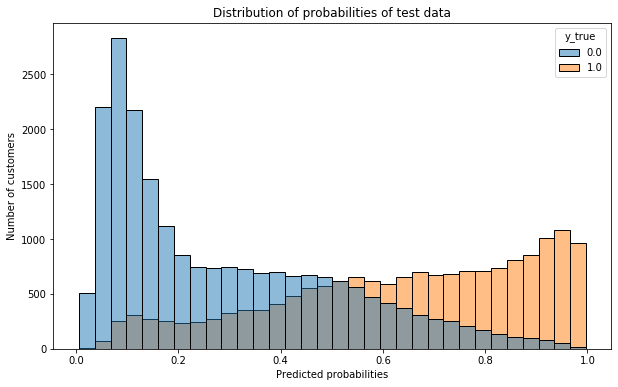

In [143]:
plt.subplots(figsize = (10, 6))
sns.histplot(tbl_clients, x = 'y_proba',hue = 'y_true')
plt.title("Distribution of probabilities of test data")
plt.xlabel("Predicted probabilities")
plt.ylabel("Number of customers")
plt.show()

* This is how probabilities are calibrated. We see that in general they are very well calibrated meaning that they do not need an additional process for corrections. 

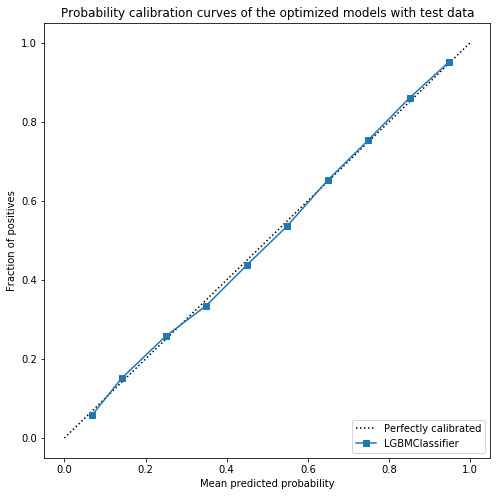

In [144]:
from sklearn.calibration import CalibrationDisplay
fig, ax = plt.subplots(figsize=(8, 8))
calibration_curve_plot = CalibrationDisplay.from_estimator(best_clf_lgb, X_test_preprocessed, y_test, ax=ax, n_bins = 10)
plt.title("Probability calibration curves of the optimized models with test data")
plt.show()

* But what if we wanted to know how each feature from the customers is influencing the probability estimations.
* Lets see a graph to see what are the most important features that help to estimate a customer's loan default.

### 8.3 What are shap values

* In a few words SHAP values tell us on average, how much each feature contributes to the probability value estimation.
* See the following intuitive [video](https://www.youtube.com/watch?v=-taOhqkiuIo) from the author of the package we are going to use.
* To learn more about the implementation of the `shap` package, see the [repository](https://github.com/slundberg/shap) and the [documentation](https://shap.readthedocs.io/en/latest/index.html).

#### 8.3.1 Variable importance - Global Interpretability

##### 8.3.1.1 Feature Importance

- This plot gives us global a high-level view of which variables have the most predictive power, the feature importance, measured as the mean absolute SHAP value.
- On the y-axis we have the 31 variables of the model input sorted from the most important to the least important, and on the x-axis we have the mean absolute SHAP values.
- This graph tells us that if we remove any of these variables, on average how much the loan default probability changes.
- Notice that this graph does not tell us in which direction each variable impacts on the probability (positively or negatively).

**Interpretation**:

- Total loans for membership subscription is one of the most important variables to estimate the probability to default. We cannot draw any conclusions on causality. What this means, is that if we do not use this variable in the model, the quality of the probability estimations will decrease.

- Average balance, average recharge, total loans for highways, whether customer does not request a loan for the last transaction or if he/she did it is already repaid and the number of total loans are among the top most important predictors of default probability.

- The question is how does these predictors increase or decrease the probability.

In [145]:
# Calculate the shap values
explainer = shap.TreeExplainer(best_clf_lgb, X_test_preprocessed, model_output="probability", feature_dependence="interventional")
shap_values = explainer.shap_values(X_test_preprocessed)

100%|===================| 38625/38737 [05:05<00:00]        

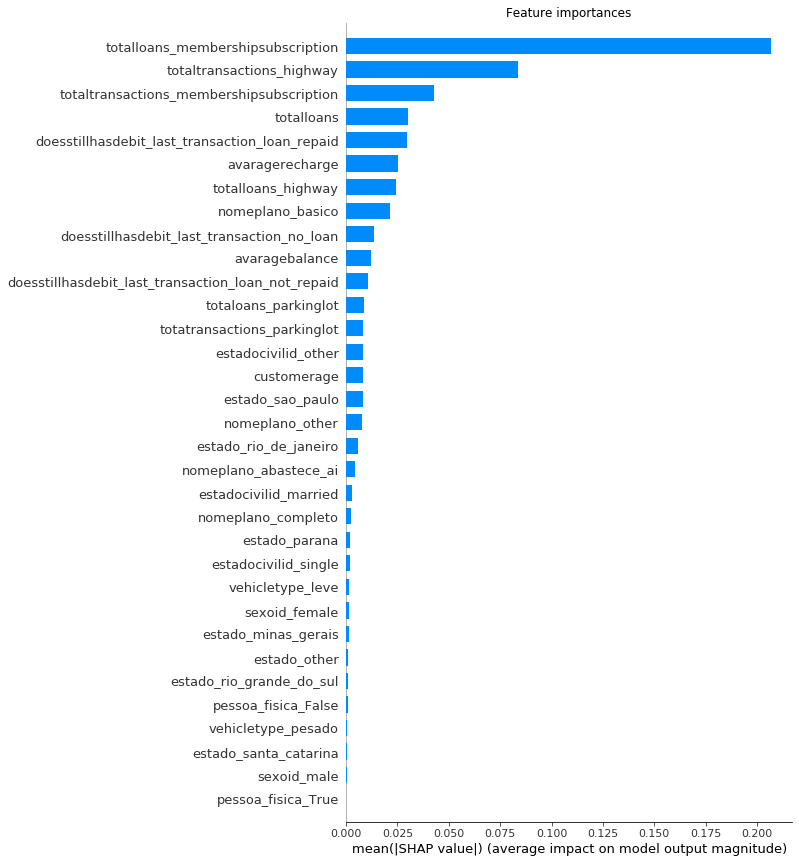

In [146]:
plt.title("Feature importances")
shap.summary_plot(shap_values, X_test_preprocessed, plot_type="bar", max_display=40, show=False)
plt.savefig('../figures/feature_importances.png')


##### 8.3.1.2 Feature Importance for each feature and sample

* Lets draw a different graph, one that can give us an insight as to how each feature impacts the average customer probability to default on a loan granted by ConectCar.
    - In the y-axis, we see the 31 variables of the input model sorted by feature importance in descending order, as in the graph above. 
    - In the X axis we see the SHAP values calculated as probabilities. 
    - Within each feature there is a cloud of dots, which belong to the sample of N customers from the test data.
    - The color tells how high or low is the value of the feature for the given customer.
    - Along the x-axis, all the dots to the left of zero for that given feature value the impact on the probability reduced the probability to default on a loan. On the other hand, if the dots are to the right of zero, the feature value for that customer increased the probability to default.
    - The width of the clouds represent the density, of customers around that value. The wider the cloud, the more customers are agglomerated around a given shap value.
    - We can see that as the feature is less important, meaning the feature is located at the bottom of the graph, the clouds of dots cluster around the value zero. That means they are not moving much the probability.
    
    
**Interpretation:**

- From the graph above we know that total loans granted to complete membership subscriptions was the most important predictor of probability to default on because it had the greatest average absolute shap value. With this new graph we know that when customers have used many loans (the value of the feature is high), as depicted by the customers in color red, the probability to default on a loan increases. The 90% percentile in the test data requested at least 3 loans for membership transactions. Moreover, we see that we have a big cloud of customers in blue on the left of the graph, those are the customers that did not requested a loan, or at most requested one loan. 50% of our customers in the test data did not used this type of loan. Notice this is as far as we can get with the explanation of how this feature impacts on the probability to default on a loan. A more in-depth explanation pointing to causality reasons require much more statistical work using experiments!


In [147]:
X_test_preprocessed[['totalloans_membershipsubscription']].describe([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
totalloans_membershipsubscription,38737.0,1.318481,3.949233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,15.0,270.0


- Lets analyze total loans for highways, customers that have used many loans to complete this transaction see their probability to default reduced. This could be a signal that these customers use a lot this service, and they have run out of balance more frequently than other clients, nonetheless because they use the highways very frequently the they repay their loans in a shorter period of days than the rest of the customers. See that customers with very few loans, likely with 2 loans at most, see their probability to default increased because they use the highways sometimes, meaning that they have not a big incentive to repay sooner than very frequent commuters.

In [148]:
X_test_preprocessed[['totalloans_highway']].describe([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
totalloans_highway,38737.0,18.786638,1680.182612,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0,5.0,7.0,14.0,87.0,318993.0


* For average balance, we see that customers with very low balance in their accounts, their probability to default increases. When the balance is very high the probability to default decreases. What is a high balance and a low balance, lets see some percentiles for this variable.

In [149]:
X_test_preprocessed[['avaragebalance']].describe([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
avaragebalance,38737.0,58.758407,7581.551617,-1317224.63,-12.73,31.13,39.642,45.09,49.44,55.53,64.02,72.25,86.97,123.304,883.426,100108.55


* For average recharge, we see that customers that make big recharges increase their probability to default. Customers with low recharges decrease the probability to default. For this particular example, we would need more information to understand why this happens. But it is clear that the algorithm is picking this pattern. Again, this is not a causality interpretation, this is an explanation of how the model is arriving to the predictions.

In [150]:
X_test_preprocessed[['avaragerecharge']].describe([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
avaragerecharge,38737.0,121.625397,769.924823,5.0,42.5,50.0,50.33,53.84,60.52,70.66,86.176,99.52,108.39,161.664,710.0164,97131.14


* In their last transaction customers did not required a loan `doesstillhasdebit_last_transaction_no_loan`, means the value is 1, the probability to default decreases. If they were granted a loan in their last transaction, their probability to default increases. See that 70% of the customers did not requested a loan.

In [151]:
X_test_preprocessed[['doesstillhasdebit_last_transaction_no_loan']].describe([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
doesstillhasdebit_last_transaction_no_loan,38737.0,0.744895,0.435926,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


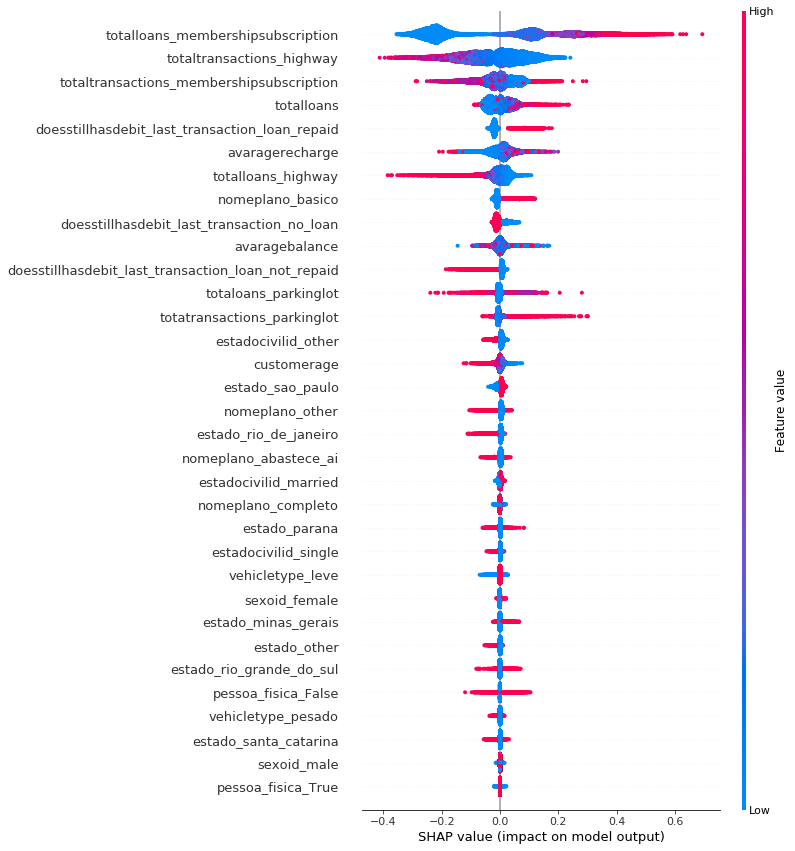

In [152]:
shap.summary_plot(shap_values, features=X_test_preprocessed,  class_inds=[1], max_display = 40)

#### 8.3.2 Variable importance - Customer level.

* Here we will make a zoom in, into a single customer in the test set.
* We are looking at the same information in the above graph, but now as a set of bars along a number line.
* Lets break down the graph:
    - In the number line there is a `base value`, that is the average probability for the test set of customers.
    - In the number line there is a `value in bold letters`, that is the predicted probability for this customer. If you see, it splits the graph in two opposing forces, those that increase the probability to a higher value, and those that push the probability to a lower value. The sum of this effects moves the probability to default from the base value to the customer probability.
    - The color is for values that increase (red) or decrease the probability (blue)
* It is called a forceplot because it shows you how each feature pulls or pushes the value of the average probability, to give the unique probability score for each customer.

**Example 1:**

* Lets take the customer with ID = `530503`.

* The true label for this customers and estimated probability to default on a loan after 15 days are shown in the table below. Identify the probability to default of this customer in the number line of the plot below, it is in **bold** and on top of it displays f(x).

In [153]:
# Show customer label
id = 530503
position = list(tbl_clients.loc[tbl_clients.clienteid == id, :].index)[0]
tbl_clients.loc[tbl_clients.clienteid == id, :]

,clienteid,y_true,y_proba
38733,530503,1.0,0.952125


* Lets calculate the average probability for the test set, better known as **base value**. Identify this value in the number line of the plot below.

In [154]:
np.round(tbl_clients.y_proba.mean(),4)

0.4407

* Lets identify these values in the graph that is a number line.

In [155]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[position], features= X_test_preprocessed.loc[tbl_clients.clienteid == id])

**Interpretation:**

* For this customer we start at the base value probability, we see that total loans membership subscritpion, total loans and average recharge are the features that increase the probability to default on the loan from the base value. On the other hand, total loans highway and average balance is pushing down the probability. The net sum of these effects gives as a result the final probability f(x).

* Notice that the graph in each feature shows the values we have in the database.

    - In the table below we show for this customer each feature, with the observed value, and the average value for the entire training set, also we see a column that indicates if the customer is above or below the average value.

In [156]:


def fun_return_report_customer_vs_average_behaviour(tbl, pos):
    '''This function returns a pandas data frame comparing the customer feature values vs the average of the test o validation set.
    tbl: (DataFrame) with preprocessed validation or test features (X)
    '''
    # Show customer features
    tbl_customer_values = tbl.iloc[pos , :].reset_index(name = 'customer_values')
    
    # Mean value of each feature
    tbl_customers_mean_values = (
        tbl
         .median()
         .reset_index(name = 'average_behaviour')
         .round(2)
    )
    # Join customer data vs average behaviour (using the median)   
    tbl_customer_vs_average_behavior = (
        pd.merge(
            tbl_customer_values, 
            tbl_customers_mean_values, 
            how = 'inner', 
            on = 'index')
    ).assign(
        customer_status = lambda df_: df_.customer_values >= df_.average_behaviour,
    )
    tbl_customer_vs_average_behavior['customer_status'] = ["above the average" if val == True else "below the average" for val in tbl_customer_vs_average_behavior.customer_status]
    
    def color_recommend(s):
        '''Colors customer status text
        '''
        return np.where(s.eq('above the average'),
                        'color: green',
                        'color: red')
    
    return tbl_customer_vs_average_behavior.style.apply(color_recommend, subset = ['customer_status'])

fun_return_report_customer_vs_average_behaviour(X_test_preprocessed, position)

,index,customer_values,average_behaviour,customer_status
0,totalloans,160.000000,3.000000,above the average
1,totalloans_highway,122.000000,2.000000,above the average
2,totaloans_parkinglot,0.000000,0.000000,above the average
3,totalloans_membershipsubscription,38.000000,0.000000,above the average
4,totaltransactions_highway,923.000000,165.000000,above the average
5,totatransactions_parkinglot,0.000000,0.000000,above the average
6,totaltransactions_membershipsubscription,248.000000,16.000000,above the average
7,avaragebalance,140.520000,55.530000,above the average
8,avaragerecharge,189.740000,70.660000,above the average
9,customerage,48.000000,41.000000,above the average


Lets see a different customer with the following id = `1625470`.

* Here we see a customer where his total loans memeberhip subscription in zero and the average balance and the total loans for highway and being a pessoa fisica lower his probability. His recharge average behavioir is much higher than the average and it increases his probability to default.

In [157]:
# Show customer label
id = 1625470
position = list(tbl_clients.loc[tbl_clients.clienteid == id, :].index)[0]
tbl_clients.loc[tbl_clients.clienteid == id, :]

,clienteid,y_true,y_proba
3,1625470,0.0,0.08383


In [158]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[position], features= X_test_preprocessed.loc[tbl_clients.clienteid == id])

In [159]:
fun_return_report_customer_vs_average_behaviour(X_test_preprocessed, position)

,index,customer_values,average_behaviour,customer_status
0,totalloans,4.000000,3.000000,above the average
1,totalloans_highway,4.000000,2.000000,above the average
2,totaloans_parkinglot,0.000000,0.000000,above the average
3,totalloans_membershipsubscription,0.000000,0.000000,above the average
4,totaltransactions_highway,372.000000,165.000000,above the average
5,totatransactions_parkinglot,2.000000,0.000000,above the average
6,totaltransactions_membershipsubscription,8.000000,16.000000,below the average
7,avaragebalance,2471.970000,55.530000,above the average
8,avaragerecharge,1495.450000,70.660000,above the average
9,customerage,41.000000,41.000000,above the average


#### 8.3.3 Dependence Plots

* Now that we undestand how to interpret the components of the graph. Let's dive deep into specific features, using dependency plots.

* On the y-axis we have the SHAP values of the impact in the probability

* On the x-axis we show the values that the variable we want to explain can take.

* In color there is another variable, and the color depicts the ranges of the variable.

In [160]:
X_test_preprocessed.describe([0.01, 0.99]).T

,count,mean,std,min,1%,50%,99%,max
totalloans,38737.0,21.510520,1847.043720,1.00,1.00,3.00,101.0000,351941.00
totalloans_highway,38737.0,18.786638,1680.182612,0.00,0.00,2.00,87.0000,318993.00
totaloans_parkinglot,38737.0,0.393939,6.773982,0.00,0.00,0.00,5.0000,1128.00
totalloans_membershipsubscription,38737.0,1.318481,3.949233,0.00,0.00,0.00,15.0000,270.00
totaltransactions_highway,38737.0,595.791311,6560.942718,0.00,0.00,165.00,5646.8000,917901.00
totatransactions_parkinglot,38737.0,5.659628,78.808005,0.00,0.00,0.00,82.6400,6742.00
totaltransactions_membershipsubscription,38737.0,21.679480,29.488402,0.00,0.00,16.00,115.0000,1526.00
avaragebalance,38737.0,58.758407,7581.551617,-1317224.63,-12.73,55.53,883.4260,100108.55
avaragerecharge,38737.0,121.625397,769.924823,5.00,42.50,70.66,710.0164,97131.14
customerage,38737.0,42.451997,10.883084,18.00,23.00,41.00,72.0000,76.00


**Total loans**

* Total loans and shap values show a nonlinear pattern. As customers increase their number of loans up to 20, the probability increases on average. After 20 loans the probability starts to increase at a lower rate. The pattern tends to be noisier after this point. We can see that the noise is correlated with a large amount of highway loans. This nonlinear component is the product of many interactions.

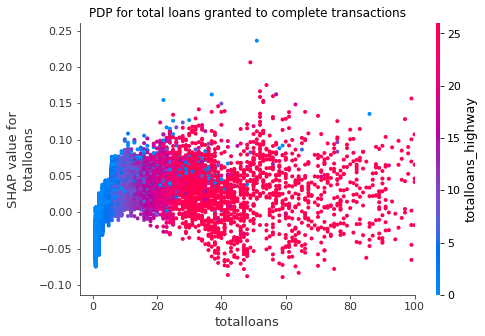

In [161]:
shap.dependence_plot('totalloans', shap_values, features=X_test_preprocessed, xmax = 100, show=False) # xmax
plt.title("PDP for total loans granted to complete transactions")
plt.show()

* Here we can see the same graphic, however now we are comparing the shap values and total loans with the interaction of average balance. We can see that the probability of default after 20 loans decreases for customers with low balances, while it increases for customers that have high balances. This is an example of how this nonlinear pattern is derivated.

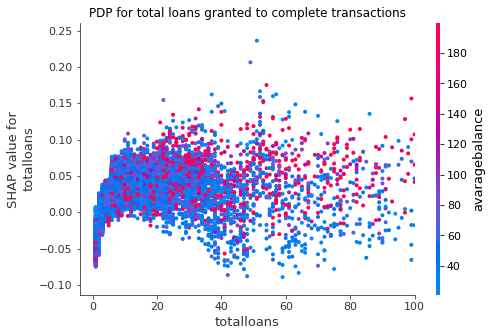

In [162]:
shap.dependence_plot('totalloans', shap_values, features=X_test_preprocessed, xmax = 100, show=False ,interaction_index='avaragebalance') # xmax
plt.title("PDP for total loans granted to complete transactions")
plt.show()

**Total loans for highways**

* The probability to default decreases as more loans for highway are granted. We can see that it decreases less for not pessoas fisicas.

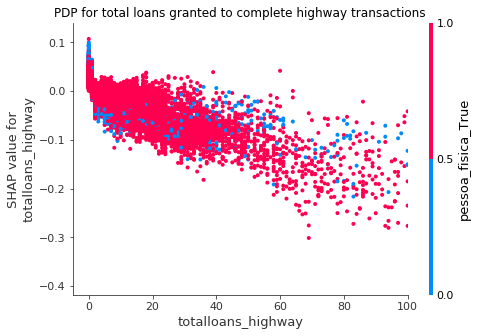

In [163]:
shap.dependence_plot('totalloans_highway', shap_values, features=X_test_preprocessed, xmax = 100, show=False, interaction_index='pessoa_fisica_True')
plt.title("PDP for total loans granted to complete highway transactions")
plt.show()

**Total loans membership subscription**

* The probability of default on a loan increases as total loans for membership subscriptions increases. We cann see that the customers that are more impacted are the ones that request the most loans.

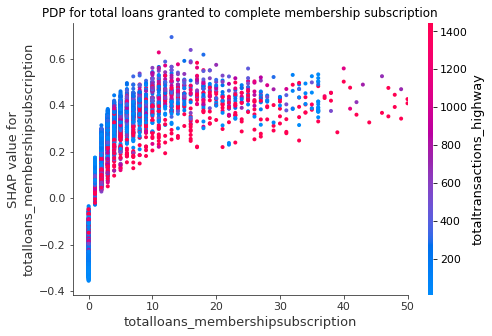

In [164]:
shap.dependence_plot('totalloans_membershipsubscription', shap_values, features=X_test_preprocessed, xmax = 50, show=False)
plt.title("PDP for total loans granted to complete membership subscription")
plt.show()

**Average recharge**

* We can see that the probability to default increases as average recharge increaes. The pattern appears to be linear when the average balance is low. For customers that their average balance is high the probability increases less.

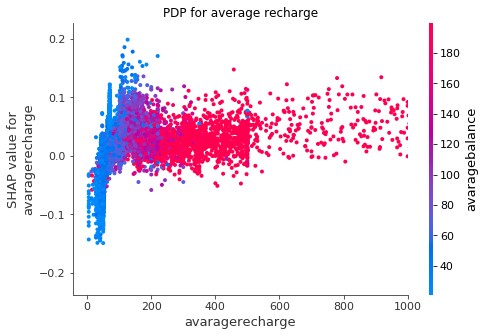

In [165]:
shap.dependence_plot('avaragerecharge', shap_values, features=X_test_preprocessed, xmax = 1000, show=False, interaction_index = 'avaragebalance')
plt.title("PDP for average recharge")
plt.show()

* Here we see the same graph as above but know we see the interaction with pessoas fisicas. We can see that for companies the increase in probability is less than with pessoas fisicas.

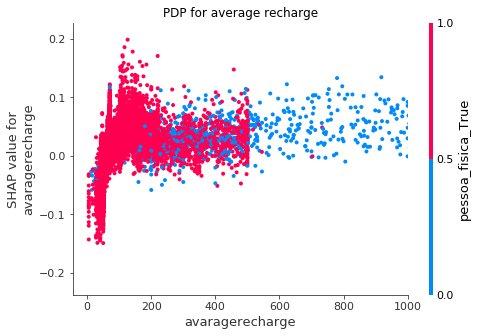

In [166]:
shap.dependence_plot('avaragerecharge', shap_values, features=X_test_preprocessed, xmax = 1000, show=False, interaction_index = 'pessoa_fisica_True')
plt.title("PDP for average recharge")
plt.show()

**Average balance**

* We can see that as average balance increases the probability to default decreases. However we see that the probability to default increases positively, only when the average recharge and average balance is low.

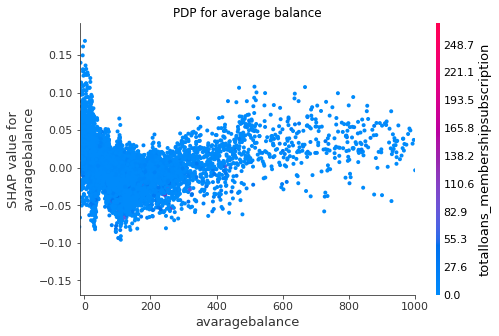

In [167]:
shap.dependence_plot('avaragebalance', shap_values, features=X_test_preprocessed, xmin = -14, xmax = 1000, show=False)
plt.title("PDP for average balance")
plt.show()

* This are some examples of how partial dependency plots can help to understand how a model arrives to the predictions. However, these explanations are not necessarily simple. Particularly when the shape values and predictor relationships are nonlinear. The interaction of more than 2 features is difficult to unravel.